In [115]:
import os
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch

import monai
import monai.transforms.spatial.old_array as old
import monai.transforms.spatial.old_dictionary as oldd
from monai.transforms.lazy.functional import apply_transforms
from monai.transforms.spatial.functional import spacing
# from monai.utils.mapping_stack import MetaMatrix
from monai.transforms import Invert, AddChannel, Compose, Crop, LoadImage, LoadImaged, EnsureChannelFirst, EnsureChannelFirstd
from monai.transforms.spatial.array import Flip, RandFlip, Resize, Rotate, RandRotate, Rotate90, RandRotate90, Spacing, Zoom, RandZoom
from monai.transforms.spatial.array import RandGridDistortion, Rand2DElastic
from monai.transforms.spatial.dictionary import Spacingd, Resized, RandFlipd, RandRotated, RandRotate90d, RandZoomd
from monai.transforms.croppad.functional import croppad
from monai.transforms.croppad.array import RandSpatialCrop, CropPad
from monai.transforms.croppad.dictionary import RandSpatialCropd, RandCropPadd
from monai.data.meta_tensor import MetaTensor
from monai.losses.dice import DiceLoss
print(monai.__version__, monai.__file__)
# !pip list | grep monai

1.1.0+76.g5f927295.dirty /home/ben/git/monai_swi/monai/__init__.py


In [114]:
display_images = dict()

In [108]:
def get_img(size, dtype=torch.float32, offset=0):
    img = torch.zeros(size, dtype=dtype)
    if len(size) == 2:
        for j in range(size[0]):
            for i in range(size[1]):
                img[j, i] = i + j * size[0] + offset
    else:
        for k in range(size[0]):
            for j in range(size[1]):
                for i in range(size[2]):
                    img[k, j, i] = i + j * size[0] + k * size[0] * size[1]
    return np.expand_dims(img, 0)

def plot_datas(datas, cols=4, tight=False, size=20):
    # print(len(datas))
    minv = min([d.min() for d in datas])
    maxv = max([d.max() for d in datas])
    rows = len(datas) // cols if len(datas) % cols == 0 else len(datas) // cols + 1
    fig, ax = plt.subplots(rows, cols, figsize=(size, size * rows / cols))
    if tight == True:
        plt.tight_layout()
    for i_d, d in enumerate(datas):
        if len(datas) <= cols:
            ax[i_d].imshow(d[0,...] if len(d.shape) > 2 else d, vmin=minv, vmax=maxv)
        else:
            ax[i_d // cols, i_d % cols].imshow(d[0,...] if len(d.shape) > 2 else d)

def rand_seed(rng):
    value = rng.randint(np.int32((1<<31) - 1), dtype=np.int32)
#     print(value, type(value))
    return value


class RNGWrapper(np.random.RandomState):

    def __init__(self, tag, rng):
        self.tag = tag
        self.rng = rng
        self.calls = 0

    def rand(self, *args, **kwargs):
        self.calls += 1
        value = self.rng.rand(*args, **kwargs)
        print(self.tag, self.calls, value)
        return value

    def randint(self, *args, **kwargs):
        self.calls += 1
        value = self.rng.randint(*args, **kwargs)
        print(self.tag, self.calls, value)
        return value

    
def find_mid_label_z(label):
    
    first_z = None
    last_z = None
    for z in range(label.shape[-1]):
        count = np.count_nonzero(label[..., z])
        if count > 0:
            if first_z is None:
                first_z = z
            last_z = z
    
    if first_z is None:
        return 0, label.shape[-1], label.shape[-1] // 2

    return first_z, last_z, int((first_z + last_z) / 2)


def find_mid_label(label):
    first_v = [None, None, None]
    last_v = [None, None, None]
    slice_dv = [lambda im, v: im[:, v, ...],
                lambda im, v: im[..., v, :],
                lambda im, v: im[..., v]]

    for d in range(3):
        for v in range(label.shape[d+1]):
            count = np.count_nonzero(slice_dv[d](label, v))
            if count > 0:
                first_v[d] = v if first_v[d] is None else first_v[d]
                last_v[d] = v
#     print("first_v:", first_v)
#     print("last_v:", last_v)
    if first_v[0] == None:
        return tuple((0, label.shape[d+1], label.shape[d+1] // 2) for d in range(3))
    
    return tuple((first_v[d], last_v[d], (last_v[d] + first_v[d]) // 2) for d in range(3))

def sanitized_range_from_extents(mid_v, max_v, range_v):
    half_range = range_v // 2
    if mid_v - half_range < 0:
        return 0, range_v
    if mid_v + half_range >= max_v:
        return max_v - range_v, max_v
    return mid_v - half_range, mid_v + half_range

def entropy(vol):
    jh, _ = np.histogram(vol.ravel(), bins=256, normed=True)
    # Add epsillon values to compensate for 0 bins
    jh = jh + np.finfo(np.float32).eps
    # Compute and return the joint entropy
    return np.sum(jh.ravel()*np.log(jh.ravel()))
    
            

In [105]:
def trad_pipeline():

    keys = ('image', 'label')
    masterrng = np.random.RandomState(12345678)

    resized = oldd.Resized(keys=keys, spatial_size=(192, 192, 72), mode=("area", "nearest"))
    randflipd = oldd.RandFlipd(keys=keys, prob=0.5, spatial_axis=[1, 2])
    randflipd.set_random_state(state=np.random.RandomState(rand_seed(masterrng)))
    rotate90d = oldd.RandRotate90d(keys=keys, prob=0.5, spatial_axes=(0, 1))
    rotate90d.set_random_state(state=np.random.RandomState(rand_seed(masterrng)))
    zoomd = oldd.RandZoomd(keys=keys, prob=1.0, min_zoom=0.75, max_zoom=1.25, mode=("area", "nearest"), keep_size=True)
    zoomd.set_random_state(state=np.random.RandomState(rand_seed(masterrng)))
    rotated = oldd.RandRotated(keys=keys, prob=1.0, range_z=(-torch.pi/4, torch.pi/4), mode=("bilinear", "nearest"), align_corners=True)
    rotated.set_random_state(state=np.random.RandomState(rand_seed(masterrng)))
    pipeline = Compose([resized, randflipd, rotate90d, zoomd, rotated])

    return pipeline


def trad_pipeline_patch_first():

    keys = ('image', 'label')
    masterrng = np.random.RandomState(12345678)
    randfliprng = np.random.RandomState(rand_seed(masterrng))
    rotate90rng = np.random.RandomState(rand_seed(masterrng))
    zoomrng = np.random.RandomState(rand_seed(masterrng))
    rotaterng = np.random.RandomState(rand_seed(masterrng))
    patch_seed = rand_seed(masterrng)
    print("lazy patch seed:", patch_seed)
    patchrng = np.random.RandomState(patch_seed)

    patchd = RandSpatialCropd(keys=keys, roi_size=(160, 160, 155), random_size=False)
    patchd.set_random_state(state=patchrng)
    resized = oldd.Spacingd(keys=keys, pixdim=(1.0, 1.0, 155/72), mode=("bilinear", "nearest"))
    randflipd = oldd.RandFlipd(keys=keys, prob=0.5, spatial_axis=[1, 2])
    randflipd.set_random_state(state=randfliprng)
    rotate90d = oldd.RandRotate90d(keys=keys, prob=0.5, spatial_axes=(0, 1))
    rotate90d.set_random_state(state=rotate90rng)
    zoomd = oldd.RandZoomd(keys=keys, prob=1.0, min_zoom=0.75, max_zoom=1.25, mode=("area", "nearest"), keep_size=True)
    zoomd.set_random_state(state=zoomrng)
    rotated = oldd.RandRotated(keys=keys, prob=1.0, range_z=(-torch.pi/4, torch.pi/4), mode=("bilinear", "nearest"), align_corners=True)
    rotated.set_random_state(state=rotaterng)
    pipeline = Compose([patchd, resized, randflipd, rotate90d, zoomd, rotated])

    return pipeline


def trad_pipeline_patch_last():

    keys = ('image', 'label')
    masterrng = np.random.RandomState(12345678)
    randfliprng = np.random.RandomState(rand_seed(masterrng))
    rotate90rng = np.random.RandomState(rand_seed(masterrng))
    zoomrng = np.random.RandomState(rand_seed(masterrng))
    rotaterng = np.random.RandomState(rand_seed(masterrng))
    patch_seed = rand_seed(masterrng)
    print("lazy patch seed:", patch_seed)
    patchrng = np.random.RandomState(patch_seed)

    resized = oldd.Spacingd(keys=keys, pixdim=(1.0, 1.0, 155/72), mode=("bilinear", "nearest"))
    randflipd = oldd.RandFlipd(keys=keys, prob=0.5, spatial_axis=[1, 2])
    randflipd.set_random_state(state=randfliprng)
    rotate90d = oldd.RandRotate90d(keys=keys, prob=0.5, spatial_axes=(0, 1))
    rotate90d.set_random_state(state=rotate90rng)
    zoomd = oldd.RandZoomd(keys=keys, prob=1.0, min_zoom=0.75, max_zoom=1.25, mode=("area", "nearest"), keep_size=True)
    zoomd.set_random_state(state=zoomrng)
    rotated = oldd.RandRotated(keys=keys, prob=1.0, range_z=(-torch.pi/4, torch.pi/4), mode=("bilinear", "nearest"), align_corners=True)
    rotated.set_random_state(state=rotaterng)
    patchd = RandSpatialCropd(keys=keys, roi_size=(160, 160, 72), random_size=False)
    patchd.set_random_state(state=patchrng)
    pipeline = Compose([resized, randflipd, rotate90d, zoomd, rotated, patchd])

    return pipeline


def trad_pipeline_label_only():

    print("trad_pipeline_label_only")
    masterrng = np.random.RandomState(12345678)
    loadimage = LoadImage(image_only=True)
    ensurech = EnsureChannelFirst()
    resize = old.Resize(spatial_size=(192, 192, 72), mode="nearest")
    randflip = old.RandFlip(prob=0.5, spatial_axis=[1, 2])
    randflip.set_random_state(state=RNGWrapper("l", np.random.RandomState(rand_seed(masterrng))))
    rotate90 = old.RandRotate90(prob=0.5, spatial_axes=(0, 1))
    rotate90.set_random_state(state=np.random.RandomState(rand_seed(masterrng)))
    zoom = old.RandZoom(prob=1.0, min_zoom=0.75, max_zoom=1.25, mode="nearest", keep_size=True)
    zoom.set_random_state(state=np.random.RandomState(rand_seed(masterrng)))
    rotate = old.RandRotate(prob=1.0, range_z=(-torch.pi/4, torch.pi/4), mode="nearest", align_corners=True)
    rotate.set_random_state(state=np.random.RandomState(rand_seed(masterrng)))
    pipeline = Compose([loadimage, ensurech, resize, randflip, rotate90, zoom, rotate])

    return pipeline


def lazy_pipeline(lazy=True):
    keys = ('image', 'label')
    masterrng = np.random.RandomState(12345678)

    pipeline = Compose([
            Resized(keys=keys, spatial_size=(192, 192, 72), mode=("bilinear", "nearest"), lazy_evaluation=lazy),
            RandFlipd(keys=keys, prob=0.5, spatial_axis=[1, 2], lazy_evaluation=lazy,
                      state=np.random.RandomState(rand_seed(masterrng))),
            RandRotate90d(keys=keys, prob=0.5, spatial_axes=(0, 1), lazy_evaluation=lazy,
                          state=np.random.RandomState(rand_seed(masterrng))),
            RandZoomd(keys=keys, prob=1.0, min_zoom=0.75, max_zoom=1.25, mode=("bilinear", "nearest"), keep_size=True, lazy_evaluation=lazy,
                      state=np.random.RandomState(rand_seed(masterrng))),
            RandRotated(keys=keys, prob=1.0, range_z=(-torch.pi/4, torch.pi/4), mode=("bilinear", "nearest"), align_corners=True, lazy_evaluation=lazy,
                        state=np.random.RandomState(rand_seed(masterrng))),        
    ])
    
    return pipeline


# def lazy_pipeline_patch_first(lazy=True):
#     keys = ('image', 'label')
#     masterrng = np.random.RandomState(12345678)
#     randfliprng = np.random.RandomState(rand_seed(masterrng))
#     rotate90rng = np.random.RandomState(rand_seed(masterrng))
#     zoomrng = np.random.RandomState(rand_seed(masterrng))
#     rotaterng = np.random.RandomState(rand_seed(masterrng))
#     patch_seed = rand_seed(masterrng)
#     print("lazy patch seed:", patch_seed)
#     patchrng = np.random.RandomState(patch_seed)

#     pipeline = Compose([
#             RandCropPadd(keys=keys, sizes=(160, 160, 155), lazy_evaluation=lazy, state=patchrng),
#             Spacingd(keys=keys, pixdim=(1.0, 1.0, 155/72), mode=("bilinear", "nearest"), lazy_evaluation=lazy),
#             RandFlipd(keys=keys, prob=0.5, spatial_axis=[1, 2], lazy_evaluation=lazy, state=randfliprng),
#             RandRotate90d(keys=keys, prob=0.5, spatial_axes=(0, 1), lazy_evaluation=lazy, state=rotate90rng),
#             RandZoomd(keys=keys, prob=1.0, min_zoom=0.75, max_zoom=1.25, mode=("bilinear", "nearest"), keep_size=True, lazy_evaluation=lazy, state=zoomrng),
#             RandRotated(keys=keys, prob=1.0, range_z=(-torch.pi/4, torch.pi/4), mode=("bilinear", "nearest"), align_corners=True, lazy_evaluation=lazy, state=rotaterng),        
#     ])
    
#     return pipeline


def lazy_pipeline_patch_first(lazy=True, **kwargs):
    keys = ('image', 'label')
    masterrng = np.random.RandomState(12345678)
    randfliprng = np.random.RandomState(rand_seed(masterrng))
    rotate90rng = np.random.RandomState(rand_seed(masterrng))
    zoomrng = np.random.RandomState(rand_seed(masterrng))
    rotaterng = np.random.RandomState(rand_seed(masterrng))
    patch_seed = rand_seed(masterrng)
    print("lazy patch seed:", patch_seed)
    patchrng = np.random.RandomState(patch_seed)

    pipeline = Compose([
        RandCropPadd(keys=keys, sizes=(160, 160, 155), lazy_evaluation=lazy, state=patchrng),
        Resized(keys=keys, spatial_size=(160, 160, 72), mode=("bilinear", "nearest"), lazy_evaluation=lazy),
        RandFlipd(keys=keys, prob=0.5, spatial_axis=[1, 2], lazy_evaluation=lazy, state=randfliprng),
        RandRotate90d(keys=keys, prob=0.5, spatial_axes=(0, 1), lazy_evaluation=lazy, state=rotate90rng),
        RandZoomd(keys=keys, prob=1.0, min_zoom=0.75, max_zoom=1.25, mode=("bilinear", "nearest"), keep_size=True,
                  lazy_evaluation=lazy, state=zoomrng),
        RandRotated(keys=keys, prob=1.0, range_z=(-torch.pi / 4, torch.pi / 4), mode=("bilinear", "nearest"),
                    align_corners=True, lazy_evaluation=lazy, state=rotaterng),
    ])

    return pipeline


# def lazy_pipeline_patch_last(lazy=True):
#     keys = ('image', 'label')
#     masterrng = np.random.RandomState(12345678)
#     randfliprng = np.random.RandomState(rand_seed(masterrng))
#     rotate90rng = np.random.RandomState(rand_seed(masterrng))
#     zoomrng = np.random.RandomState(rand_seed(masterrng))
#     rotaterng = np.random.RandomState(rand_seed(masterrng))
#     patch_seed = rand_seed(masterrng)
#     print("lazy patch seed:", patch_seed)
#     patchrng = np.random.RandomState(patch_seed)

#     pipeline = Compose([
#             Spacingd(keys=keys, pixdim=(1.0, 1.0, 155/72), mode=("bilinear", "nearest"), lazy_evaluation=lazy),
#             RandFlipd(keys=keys, prob=0.5, spatial_axis=[1, 2], lazy_evaluation=lazy, state=randfliprng),
#             RandRotate90d(keys=keys, prob=0.5, spatial_axes=(0, 1), lazy_evaluation=lazy, state=rotate90rng),
#             RandZoomd(keys=keys, prob=1.0, min_zoom=0.75, max_zoom=1.25, mode=("bilinear", "nearest"), keep_size=True, lazy_evaluation=lazy, state=zoomrng),
#             RandRotated(keys=keys, prob=1.0, range_z=(-torch.pi/4, torch.pi/4), mode=("bilinear", "nearest"), align_corners=True, lazy_evaluation=lazy, state=rotaterng),        
#             RandCropPadd(keys=keys, sizes=(160, 160, 72), lazy_evaluation=lazy, state=patchrng),
#     ])
    
#     return pipeline


def lazy_pipeline_patch_last(lazy=True, **kwargs):

    keys = ('image', 'label')
    masterrng = np.random.RandomState(12345678)
    randfliprng = np.random.RandomState(rand_seed(masterrng))
    rotate90rng = np.random.RandomState(rand_seed(masterrng))
    zoomrng = np.random.RandomState(rand_seed(masterrng))
    rotaterng = np.random.RandomState(rand_seed(masterrng))
    patch_seed = rand_seed(masterrng)
    print("lazy patch seed:", patch_seed)
    patchrng = np.random.RandomState(patch_seed)

    pipeline = Compose([
        Resized(keys=keys, spatial_size=(240, 240, 72), mode=("bilinear", "nearest"), lazy_evaluation=lazy),
        RandFlipd(keys=keys, prob=0.5, spatial_axis=[1, 2], lazy_evaluation=lazy, state=randfliprng),
        RandRotate90d(keys=keys, prob=0.5, spatial_axes=(0, 1), lazy_evaluation=lazy, state=rotate90rng),
        RandZoomd(keys=keys, prob=1.0, min_zoom=0.75, max_zoom=1.25, mode=("bilinear", "nearest"), keep_size=True,
                  lazy_evaluation=lazy, state=zoomrng),
        RandRotated(keys=keys, prob=1.0, range_z=(-torch.pi / 4, torch.pi / 4), mode=("bilinear", "nearest"),
                    align_corners=True, lazy_evaluation=lazy, state=rotaterng),
        RandCropPadd(keys=keys, sizes=(160, 160, 72), lazy_evaluation=lazy, state=patchrng),
    ])

    return pipeline


def lazy_pipeline_label_only(lazy=True):
    masterrng = np.random.RandomState(12345678)

    print("lazy_pipeline_label_only")
    pipeline = Compose([
            LoadImage(image_only=True),
            EnsureChannelFirst(),
            Resize(spatial_size=(192, 192, 72), mode="nearest", lazy_evaluation=lazy),
            RandFlip(prob=0.5, spatial_axis=[1, 2], lazy_evaluation=lazy,
                     state=RNGWrapper("t", np.random.RandomState(rand_seed(masterrng)))),
            RandRotate90(prob=0.5, spatial_axes=(0, 1), lazy_evaluation=lazy,
                         state=np.random.RandomState(rand_seed(masterrng))),
            RandZoom(prob=1.0, min_zoom=0.75, max_zoom=1.25, mode="nearest", keep_size=True, lazy_evaluation=lazy,
                     state=np.random.RandomState(rand_seed(masterrng))),
            RandRotate(prob=1.0, range_z=(-torch.pi/4, torch.pi/4), mode="nearest", align_corners=True, lazy_evaluation=lazy,
                       state=np.random.RandomState(rand_seed(masterrng))),        
    ])
    
    return pipeline

# Rotate

In [ ]:
data = get_img((32, 32))
print(data.shape)

datas = []
print("rotate 0")
angle = torch.pi / 8
print(old.__file__)
r1 = old.Rotate(angle,
            keep_size=True,
            padding_mode="zeros")

datas.append(data)
data1 = r1(data)
datas.append(data1)
print("data1:", data1.shape, data1)

print("rotate 1")
r2 = Rotate(angle,
            padding_mode="zeros",
            keep_size=True,
            lazy_evaluation=False)
data2 = r2(data)
datas.append(data2)
print("data2:", data2.shape)

print("rotate 2")
r3 = Rotate(angle,
            padding_mode="zeros",
            keep_size=True)
r3.lazy_evalution = True
data3a = r3(data)
data3 = apply_transforms(data3a)
datas.append(data3)
print("data3:", data3.shape)

diff2_1 = data2 - data1
datas.append(diff2_1)
diff3_1 = data3 - data1
datas.append(diff3_1)
diff3_2 = data3 - data2
print(np.unique(diff3_1, return_counts=True))
datas.append(diff3_2)
plot_datas(datas)

# Rotate

In [ ]:
data = get_img((32, 32))
data[0,7:9,7:9] = 1096
data[0,15:17,:] = 1160
data[0,0,:] = 1224
data[0,:,0] = 1286
print(data.shape)

angle = torch.pi / 8
def old_rotate(keep_size=True):
    z1 = old.Rotate(angle, mode="nearest", padding_mode="zeros", keep_size=True)
    z2 = old.Rotate(angle, mode="bilinear", padding_mode="zeros", keep_size=True)
    z3 = old.Rotate(angle, mode="nearest", padding_mode="zeros", keep_size=False)
    z4 = old.Rotate(angle, mode="bilinear", padding_mode="zeros", keep_size=False)
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = z1(imgs)
        datas.append(data1)
        data2 = z2(imgs)
        datas.append(data2)
        data3 = z3(imgs)
        datas.append(data3)
        data4 = z4(imgs)
        datas.append(data4)
        return datas

    return _inner

def new_rotate(keep_size=True):
    z1 = Rotate(angle, mode="nearest", padding_mode="zeros", keep_size=True, lazy_evaluation=False)
    z2 = Rotate(angle, mode="bilinear", padding_mode="zeros", keep_size=True, lazy_evaluation=False)
    z3 = Rotate(angle, mode="nearest", padding_mode="zeros", keep_size=False, lazy_evaluation=False)
    z4 = Rotate(angle, mode="bilinear", padding_mode="zeros", keep_size=False, lazy_evaluation=False)

    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = z1(imgs)
        print(data1.affine)
        print(data1.affine)
        datas.append(data1)
        data2 = z2(imgs)
        datas.append(data2)
        data3 = z3(imgs)
        datas.append(data3)
        data4 = z4(imgs)
        datas.append(data4)
        return datas
    
    return _inner

old_results = old_rotate(False)(data)
new_results = new_rotate(False)(data)

diffs = []
for o, n in zip(old_results, new_results):
    diffs.append(n - o)

plot_datas(old_results + new_results + diffs, cols=5)

# Zoom

In [ ]:
data = get_img((32, 32))
data[0,7:9,7:9] = 1096
data[0,15:17,:] = 1160
data[0,0,:] = 1224
data[0,:,0] = 1286
print(data.shape)

def old_zoom(keep_size=True):
    z1 = old.Zoom(2, mode="nearest", padding_mode="zeros", keep_size=keep_size)
    z2 = old.Zoom(2, mode="bilinear", padding_mode="zeros", keep_size=keep_size)
    z3 = old.Zoom(0.5, mode="nearest", padding_mode="constant", keep_size=keep_size)
    z4 = old.Zoom(0.5, mode="bilinear", padding_mode="constant", keep_size=keep_size)
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = z1(imgs)
        datas.append(data1)
        data2 = z2(imgs)
        datas.append(data2)
        data3 = z3(imgs)
        datas.append(data3)
        data4 = z4(imgs)
        datas.append(data4)
        return datas

    return _inner

def new_zoom(keep_size=True):
    z1 = Zoom(2, mode="nearest", padding_mode="zeros", keep_size=keep_size, lazy_evaluation=False)
    z2 = Zoom(2, mode="bilinear", padding_mode="zeros", keep_size=keep_size, lazy_evaluation=False)
    z3 = Zoom(0.5, mode="nearest", padding_mode="zeros", keep_size=keep_size, lazy_evaluation=False)
    z4 = Zoom(0.5, mode="bilinear", padding_mode="zeros", keep_size=keep_size, lazy_evaluation=False)

    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = z1(imgs)
        print(data1.affine)
        print(data1.affine)
        datas.append(data1)
        data2 = z2(imgs)
        datas.append(data2)
        data3 = z3(imgs)
        datas.append(data3)
        data4 = z4(imgs)
        datas.append(data4)
        return datas
    
    return _inner

old_results = old_zoom(True)(data)
new_results = new_zoom(True)(data)

diffs = []
for o, n in zip(old_results, new_results):
    diffs.append(n - o)

plot_datas(old_results + new_results + diffs, cols=5)

# Resize

In [ ]:
data = get_img((32, 32))
data[0,7:9,7:9] = 1096
data[0,15:17,:] = 1160
data[0,0,:] = 1224
data[0,:,0] = 1286
print(data.shape)

zoom_in = (48, 48)
zoom_out = (24, 24)
def old_resize():
    t1 = old.Resize(zoom_in, mode="nearest")
    t2 = old.Resize(zoom_in, mode="bilinear")
    t3 = old.Resize(zoom_out, mode="nearest")
    t4 = old.Resize(zoom_out, mode="bilinear")
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = t1(imgs)
        datas.append(data1)
        data2 = t2(imgs)
        datas.append(data2)
        data3 = t3(imgs)
        datas.append(data3)
        data4 = t4(imgs)
        datas.append(data4)
        return datas

    return _inner

def new_resize():
    t1 = Resize(zoom_in, mode="nearest", lazy_evaluation=False)
    t2 = Resize(zoom_in, mode="bilinear", lazy_evaluation=False)
    t3 = Resize(zoom_out, mode="nearest", lazy_evaluation=False)
    t4 = Resize(zoom_out, mode="bilinear", lazy_evaluation=False)

    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = t1(imgs)
#         print(data1.affine)
#         data1.pending_operations[0].matrix.data[0,0] = 0.5
#         data1.pending_operations[0].matrix.data[1,1] = 0.5
#         print(data1.pending_operations[0].matrix.data)
#         data1 = apply_transforms(data1)[0]
        datas.append(data1)
        data2 = t2(imgs)
        datas.append(data2)
        data3 = t3(imgs)
        datas.append(data3)
        data4 = t4(imgs)
        datas.append(data4)
        return datas
    
    return _inner

old_results = old_resize()(data)
new_results = new_resize()(data)

diffs = []
# for o, n in zip(old_results, new_results):
#     diffs.append(n - o)

plot_datas(old_results + new_results + diffs, cols=5)

# Spacing

In [ ]:
data = get_img((32, 32))
data[0,7:9,7:9] = 1096
data[0,15:17,:] = 1160
data[0,0,:] = 1224
data[0,:,0] = 1286
print(data.shape)

dest_pixdim = (1.0, 1.0)
big_src_pixdim = (2.0, 2.0)
sml_src_pixdim = (0.5, 0.5)

def old_spacing():
    t1 = old.Spacing(dest_pixdim, mode="nearest")
    t2 = old.Spacing(dest_pixdim, mode="bilinear")
    t3 = old.Spacing(dest_pixdim, mode="nearest")
    t4 = old.Spacing(dest_pixdim, mode="bilinear")
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        mt = MetaTensor(imgs)
        mt.affine = torch.tensor([[big_src_pixdim[0], 0.0, 0.0, 0.0],
                                  [0.0, big_src_pixdim[1], 0.0, 0.0],
                                  [0.0, 0.0, 1.0, 0.0],
                                  [0.0, 0.0, 0.0, 1.0]])
        data1 = t1(mt)
        datas.append(data1)
        mt = MetaTensor(imgs)
        mt.affine = torch.tensor([[big_src_pixdim[0], 0.0, 0.0, 0.0],
                                  [0.0, big_src_pixdim[1], 0.0, 0.0],
                                  [0.0, 0.0, 1.0, 0.0],
                                  [0.0, 0.0, 0.0, 1.0]])
        data2 = t2(mt)
        datas.append(data2)
        mt = MetaTensor(imgs)
        mt.affine = torch.tensor([[sml_src_pixdim[0], 0.0, 0.0, 0.0],
                                  [0.0, sml_src_pixdim[1], 0.0, 0.0],
                                  [0.0, 0.0, 1.0, 0.0],
                                  [0.0, 0.0, 0.0, 1.0]])
        data3 = t3(mt)
        datas.append(data3)
        mt = MetaTensor(imgs)
        mt.affine = torch.tensor([[sml_src_pixdim[0], 0.0, 0.0, 0.0],
                                  [0.0, sml_src_pixdim[1], 0.0, 0.0],
                                  [0.0, 0.0, 1.0, 0.0],
                                  [0.0, 0.0, 0.0, 1.0]])
        data4 = t4(mt)
        datas.append(data4)
        return datas

    return _inner

def new_spacing():
    t1 = Spacing(dest_pixdim, mode="nearest", lazy_evaluation=False)
#     t1 = lambda x: spacing(x, dest_pixdim, big_src_pixdim, mode="nearest", padding_mode="zeros", lazy_evaluation=False)
    t2 = Spacing(dest_pixdim, mode="bilinear", lazy_evaluation=False)
#     t2 = lambda x: spacing(x, dest_pixdim, big_src_pixdim, mode="bilinear", padding_mode="zeros", lazy_evaluation=False)
    t3 = Spacing(dest_pixdim, mode="nearest", lazy_evaluation=False)
#     t3 = lambda x: spacing(x, dest_pixdim, sml_src_pixdim, mode="nearest", padding_mode="zeros", lazy_evaluation=False)
    t4 = Spacing(dest_pixdim, mode="bilinear", lazy_evaluation=False)
#     t4 = lambda x: spacing(x, dest_pixdim, sml_src_pixdim, mode="bilinear", padding_mode="zeros", lazy_evaluation=False)

    def _inner(imgs):
        datas = []
        datas.append(imgs)
        mt = MetaTensor(imgs)
        mt.affine[0, 0] = big_src_pixdim[0]
        mt.affine[1, 1] = big_src_pixdim[1]
        data1 = t1(mt)
        datas.append(data1)
        mt = MetaTensor(imgs)
        mt.affine[0, 0] = big_src_pixdim[0]
        mt.affine[1, 1] = big_src_pixdim[1]
        data2 = t2(mt)
        datas.append(data2)
        mt = MetaTensor(imgs)
        mt.affine[0, 0] = sml_src_pixdim[0]
        mt.affine[1, 1] = sml_src_pixdim[1]
        data3 = t3(mt)
        datas.append(data3)
        mt = MetaTensor(imgs)
        mt.affine[0, 0] = sml_src_pixdim[0]
        mt.affine[1, 1] = sml_src_pixdim[1]
        data4 = t4(mt)
        datas.append(data4)
        return datas
    
    return _inner

old_results = old_spacing()(data)
new_results = new_spacing()(data)

for d in old_results:
    print(d.shape)

for d in new_results:
    print(d.shape)

diffs = []
# for o, n in zip(old_results, new_results):
#     diffs.append(n - o)

plot_datas(old_results + new_results + diffs, cols=5)

# Flip

In [ ]:
data = get_img((32, 32))
data[0,7:9,7:9] = 1096
data[0,15:17,:] = 1160
data[0,0,:] = 1224
data[0,:,0] = 1286
print(data.shape)

def old_resize():
    t1 = old.Flip(0)
    t2 = old.Flip(1)
    t3 = old.Flip((0, 1))
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = t1(imgs)
        datas.append(data1)
        data2 = t2(imgs)
        datas.append(data2)
        data3 = t3(imgs)
        datas.append(data3)
        return datas

    return _inner

def new_resize():
    t1 = Flip(0, lazy_evaluation=False)
    t2 = Flip(1, lazy_evaluation=False)
    t3 = Flip((0, 1), lazy_evaluation=False)

    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = t1(imgs)
        datas.append(data1)
        data2 = t2(imgs)
        datas.append(data2)
        data3 = t3(imgs)
        datas.append(data3)
        return datas
    
    return _inner

old_results = old_resize()(data)
new_results = new_resize()(data)

diffs = []
# for o, n in zip(old_results, new_results):
#     diffs.append(n - o)

plot_datas(old_results + new_results + diffs, cols=4)

# Rotate90

In [ ]:
data = get_img((32, 24))
data[0,7:9,7:9] = 1096
data[0,15:17,:] = 1160
data[0,0,:] = 1224
data[0,:,0] = 1286
print(data.shape)

def old_resize():
    t1 = old.Rotate90(0)
    t2 = old.Rotate90(1)
    t3 = old.Rotate90(2)
    t4 = old.Rotate90(3)
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = t1(imgs)
        datas.append(data1)
        data2 = t2(imgs)
        datas.append(data2)
        data3 = t3(imgs)
        datas.append(data3)
        data4 = t4(imgs)
        datas.append(data4)
        return datas

    return _inner

def new_resize():
    t1 = Rotate90(0, lazy_evaluation=False)
    t2 = Rotate90(1, lazy_evaluation=False)
    t3 = Rotate90(2, lazy_evaluation=False)
    t4 = Rotate90(3, lazy_evaluation=False)

    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = t1(imgs)
#         print(data1.affine)
#         data1.pending_operations[0].matrix.data[0,0] = 0.5
#         data1.pending_operations[0].matrix.data[1,1] = 0.5
#         print(data1.pending_operations[0].matrix.data)
#         data1 = apply_transforms(data1)[0]
        datas.append(data1)
        data2 = t2(imgs)
        datas.append(data2)
        data3 = t3(imgs)
        datas.append(data3)
        data4 = t4(imgs)
        datas.append(data4)
        return datas
    
    return _inner

old_results = old_resize()(data)
new_results = new_resize()(data)

diffs = []
# for o, n in zip(old_results, new_results):
#     diffs.append(n - o)

plot_datas(old_results + new_results + diffs, cols=5)

# Resize / Crop

In [ ]:
data = get_img((32, 32))
data[0,7:9,7:9] = 1096
data[0,15:17,:] = 1160
data[0,0,:] = 1224
data[0,:,0] = 1286
print(data.shape)

def old_rotate_then_crop():
    c1 = Crop()
    r1 = old.Rotate(torch.pi / 4, keep_size=False, padding_mode="zeros")
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = r1(imgs)
        datas.append(data1)
        data2 = c1(data1, slices=(slice(0,16), slice(0,16)))
        datas.append(data2)
        return datas
    return _inner

def old_crop_then_rotate():
    c1 = Crop()
    r1 = old.Rotate(torch.pi / 4, keep_size=False, padding_mode="zeros")
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = c1(imgs, slices=(slice(0,16), slice(0,16)))
        datas.append(data1)
        data2 = r1(data1)
        datas.append(data2)
        return datas
    return _inner

def new_rotate_then_crop(lazy=False):
    r1 = Rotate(torch.pi / 4, keep_size=False, padding_mode="zeros", lazy_evaluation=lazy)
    c1 = CropPad(padding_mode="zeros", lazy_evaluation=False)
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = r1(imgs)
        datas.append(data1)
        data2 = c1(data1, slices=(slice(0,16), slice(0,16)))
        datas.append(data2)
        return datas
    return _inner

def new_crop_then_rotate(lazy=False):
    c1 = CropPad(padding_mode="zeros", lazy_evaluation=lazy)
    r1 = Rotate(torch.pi / 4, keep_size=False, padding_mode="zeros", lazy_evaluation=False)
    
    def _inner(imgs):
        datas = []
        datas.append(imgs)
        data1 = c1(imgs, slices=(slice(0,16), slice(0,16)))
        datas.append(data1)
        data2 = r1(data1)
        datas.append(data2)
        return datas
    return _inner

# crops = (old_rotate_then_crop(), new_rotate_then_crop(False), new_rotate_then_crop(True),
#          old_crop_then_rotate(), new_crop_then_rotate(False), new_crop_then_rotate(True))
crops = (old_rotate_then_crop(), old_crop_then_rotate(), new_crop_then_rotate(True))
for t in crops:
    datas = t(data)
    plot_datas(datas, 3)


# Functional croppad

In [ ]:
def do_functional_croppad():
    data = get_img((16, 16))
    data[0,7:9,7:9] = 1096
    data[0,15:17,:] = 1160
    data[0,0,:] = 1224
    data[0,:,0] = 1286
    print(data.shape)

    img00 = croppad(data, slices=(slice(0, 8), slice(0, 8)), padding_mode="zeros")
#     img00.push_pending_transform(MetaMatrix(tx, md))
    actual00 = apply_transforms(img00)

    img10 = croppad(data, slices=(slice(1, 9), slice(0, 8)), padding_mode="zeros")
#     img10.push_pending_transform(MetaMatrix(tx, md))
    actual10 = apply_transforms(img10)

    c = Crop()
    actual10_2 = c(data, slices=(slice(1, 9), slice(0, 8)))

    plot_datas([data, actual00, actual10, actual10_2])

do_functional_croppad()

# Trad vs lazy - forward pass results

## Entropy - whole volume

10 141 75


Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


ovol: -0.44311120131937975 tvol: -0.5254445716988609 lvol: -0.4482721994159677
ovol: -0.44311120131937975 tvol: -0.5053248873702056 lvol: -0.4289296268729898
ovol: -0.44311120131937975 tvol: -0.5257666333637427 lvol: -0.44651717009131064
ovol: -0.44311120131937975 tvol: -0.4185541374082884 lvol: -0.36717499347126215
ovol: -0.44311120131937975 tvol: -0.6223610710233693 lvol: -0.5163025613180311
ovol: -0.44311120131937975 tvol: -0.5706122085389952 lvol: -0.48348110324083005
ovol: -0.44311120131937975 tvol: -0.5901356124892108 lvol: -0.4983918712111845
ovol: -0.44311120131937975 tvol: -0.45334079076036055 lvol: -0.38482593263728376
trad time: 8.078799724578857, lazy time: 5.5228047370910645


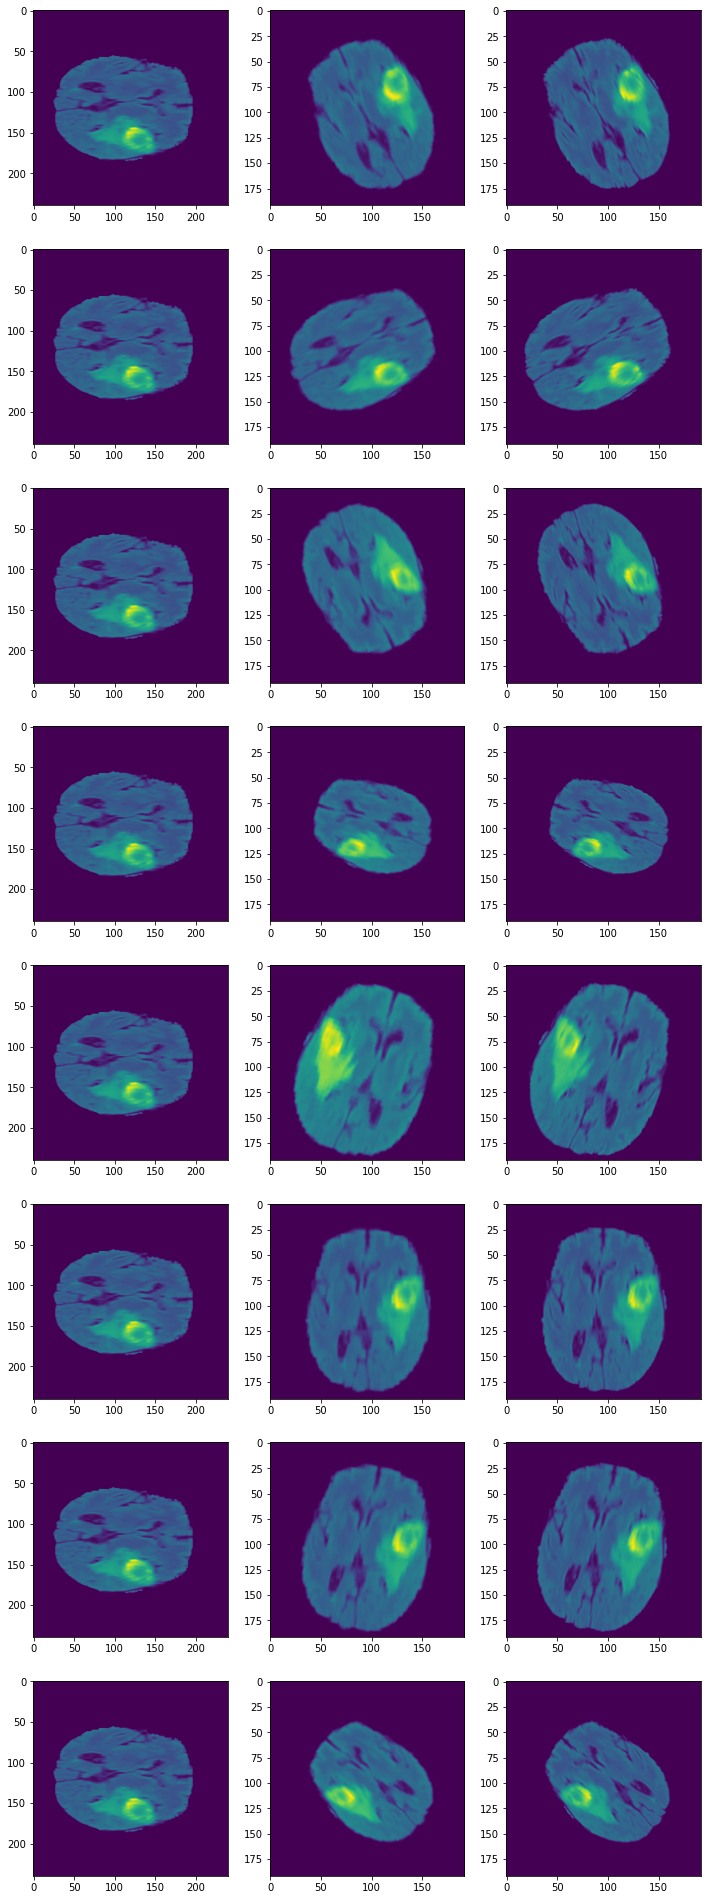

In [109]:
import time

import numpy as np
import nibabel as nib

def check_entropy_whole_pipeline():
    base_dir = '/home/ben/data/preprocessed/Task01_BrainTumour/orig'
    sample_str = 'BRATS_{}_{}.nii.gz'
    sample = '001'

    img = nib.load(os.path.join(base_dir, sample_str.format(sample, 'image')))
    lbl = nib.load(os.path.join(base_dir, sample_str.format(sample, 'label')))

    ddict = {'image': img.get_fdata(), 'label': lbl.get_fdata()}

    ddict['image'] = np.transpose(ddict['image'], axes=(3, 0, 1, 2))
    ddict['label'] = np.expand_dims(ddict['label'], axis=0)

    # print(ddict['image'].shape, ddict['label'].shape)

    tp = trad_pipeline()
    lp = lazy_pipeline(True)

    pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['image'])
    p_label_exts = find_mid_label(ddict['image'])
    # print("mid-label:", p_label_exts, tuple(p[1] - p[0] for p in p_label_exts))
    p_slice_x = slice(*sanitized_range_from_extents(p_label_exts[0][2], ddict['image'].shape[1], int(100 * 240 / 192)))
    p_slice_y = slice(*sanitized_range_from_extents(p_label_exts[1][2], ddict['image'].shape[2], int(100 * 240 / 192)))
    # print("extents:", p_slice_x, p_slice_y)

    num_samples = 8
    print(pre_first_z, pre_last_z, pre_mid_slice)
    vols = []
    results = []
    t_time = 0
    l_time = 0
    for i in range(num_samples):
        t_start = time.time()
        t_out = tp(ddict)
        t_time += time.time() - t_start
        # t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
        t_label_exts = find_mid_label(t_out['image'])
        # print("mid-label:", t_label_exts, tuple(t[1] - t[0] for t in t_label_exts))
        t_slice_x = slice(*sanitized_range_from_extents(t_label_exts[0][2], t_out['image'].shape[1], 100))
        t_slice_y = slice(*sanitized_range_from_extents(t_label_exts[1][2], t_out['image'].shape[2], 100))
        # print("extents:", t_slice_x, t_slice_y)
        # print(t_first_z, t_last_z, t_mid_slice)

        l_start = time.time()
        l_out = lp(ddict)
        l_time += time.time() - l_start
        # l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
        l_label_exts = find_mid_label(l_out['image'])
        # print("mid-label:", l_label_exts, tuple(l[1] - l[0] for l in l_label_exts))
        l_slice_x = slice(*sanitized_range_from_extents(l_label_exts[0][2], l_out['image'].shape[1], 100))
        l_slice_y = slice(*sanitized_range_from_extents(l_label_exts[1][2], l_out['image'].shape[2], 100))
        # print("extents:", l_slice_x, l_slice_y)
        # print(l_first_z, l_last_z, l_mid_slice)
    
        vols.extend([ddict['image'][0, ...],
                     t_out['image'][1, ...],
                     l_out['image'][2, ...]])

        results.extend([ddict['image'][0, ..., pre_mid_slice],
                        t_out['image'][0, ..., t_label_exts[2][2]],
                        l_out['image'][0, ..., l_label_exts[2][2]]])
        
    for i_r in range(8):
        ovol = vols[i_r * 3]
        tvol = vols[i_r * 3 + 1]
        lvol = vols[i_r * 3 + 2]
        print("ovol:", entropy(ovol),
              "tvol:", entropy(tvol),
              "lvol:", entropy(lvol))
            

    print(f"trad time: {t_time}, lazy time: {l_time}")
    plot_datas(results, 3, tight=True, size=10)
    
check_entropy_whole_pipeline()

In [72]:
entropy_by_vol =np.asarray([
    [-0.5254445716988609, -0.4482721994159677],
    [-0.5053248873702056, -0.4289296268729898],
    [-0.5257666333637427, -0.44651717009131064],
    [-0.4185541374082884, -0.36717499347126215],
    [-0.6223610710233693, -0.5163025613180311],
    [-0.5706122085389952, -0.48348110324083005],
    [-0.5901356124892108, -0.4983918712111845],
    [-0.45334079076036055, -0.38482593263728376],
])

print(entropy_by_vol[:, 0])
print(entropy_by_vol[:, 1])
print("mean:", entropy_by_vol[:, 0].mean(), entropy_by_vol[:, 1].mean())
print("std:", entropy_by_vol[:, 0].std(), entropy_by_vol[:, 1].std())

[-0.52544457 -0.50532489 -0.52576663 -0.41855414 -0.62236107 -0.57061221
 -0.59013561 -0.45334079]
[-0.4482722  -0.42892963 -0.44651717 -0.36717499 -0.51630256 -0.4834811
 -0.49839187 -0.38482593]
mean: -0.5264424890816293 -0.44673693228235745
std: 0.0638742053711932 0.04916848966724359


## Entropy - patch first

lazy patch seed: 1540998321
lazy patch seed: 1540998321
10 141 75
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)


Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


ovol: -0.44311120131937975 tvol: -0.6474312370041032 lvol: -0.5746644873304773
ovol: -0.44311120131937975 tvol: -0.5820207582029828 lvol: -0.5154538747569736
ovol: -0.44311120131937975 tvol: -0.6303136122149402 lvol: -0.5550618036447265
ovol: -0.44311120131937975 tvol: -0.5225025523734912 lvol: -0.45886897465822146
ovol: -0.44311120131937975 tvol: -0.7313230393674943 lvol: -0.6375291263882021
ovol: -0.44311120131937975 tvol: -0.6009636467276522 lvol: -0.5386724596584971
ovol: -0.44311120131937975 tvol: -0.658219893839086 lvol: -0.5855626119150623
ovol: -0.44311120131937975 tvol: -0.5656265423842755 lvol: -0.481065145373282
trad time: 5.7864813804626465, lazy time: 4.144790172576904


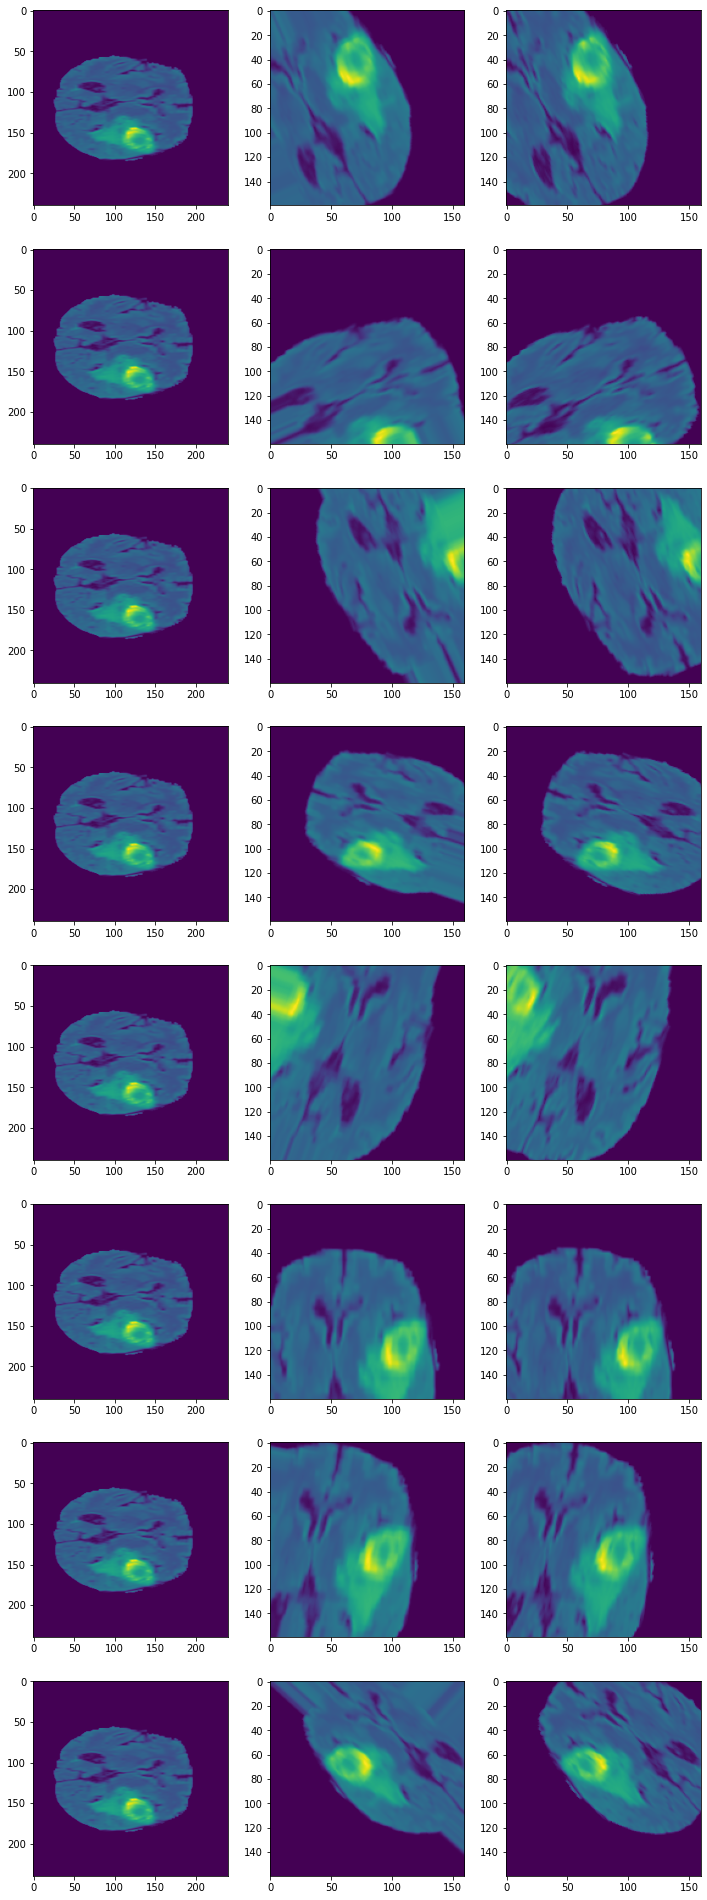

In [110]:
import time

import numpy as np
import nibabel as nib

def check_entropy_patch_first_pipeline():
    base_dir = '/home/ben/data/preprocessed/Task01_BrainTumour/orig'
    sample_str = 'BRATS_{}_{}.nii.gz'
    sample = '001'

    img = nib.load(os.path.join(base_dir, sample_str.format(sample, 'image')))
    lbl = nib.load(os.path.join(base_dir, sample_str.format(sample, 'label')))

    ddict = {'image': img.get_fdata(), 'label': lbl.get_fdata()}

    ddict['image'] = np.transpose(ddict['image'], axes=(3, 0, 1, 2))
    ddict['label'] = np.expand_dims(ddict['label'], axis=0)

    # print(ddict['image'].shape, ddict['label'].shape)

    tp = trad_pipeline_patch_first()
    lp = lazy_pipeline_patch_first(True)

    pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['image'])
    p_label_exts = find_mid_label(ddict['image'])
    # print("mid-label:", p_label_exts, tuple(p[1] - p[0] for p in p_label_exts))
    p_slice_x = slice(*sanitized_range_from_extents(p_label_exts[0][2], ddict['image'].shape[1], int(100 * 240 / 192)))
    p_slice_y = slice(*sanitized_range_from_extents(p_label_exts[1][2], ddict['image'].shape[2], int(100 * 240 / 192)))
    # print("extents:", p_slice_x, p_slice_y)

    num_samples = 8
    print(pre_first_z, pre_last_z, pre_mid_slice)
    vols = []
    results = []
    t_time = 0
    l_time = 0
    for i in range(num_samples):
        t_start = time.time()
        t_out = tp(ddict)
        t_time += time.time() - t_start
        # t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
        t_label_exts = find_mid_label(t_out['image'])
        # print("mid-label:", t_label_exts, tuple(t[1] - t[0] for t in t_label_exts))
        t_slice_x = slice(*sanitized_range_from_extents(t_label_exts[0][2], t_out['image'].shape[1], 100))
        t_slice_y = slice(*sanitized_range_from_extents(t_label_exts[1][2], t_out['image'].shape[2], 100))
        # print("extents:", t_slice_x, t_slice_y)
        # print(t_first_z, t_last_z, t_mid_slice)

        l_start = time.time()
        l_out = lp(ddict)
        l_time += time.time() - l_start
        # l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
        l_label_exts = find_mid_label(l_out['image'])
        # print("mid-label:", l_label_exts, tuple(l[1] - l[0] for l in l_label_exts))
        l_slice_x = slice(*sanitized_range_from_extents(l_label_exts[0][2], l_out['image'].shape[1], 100))
        l_slice_y = slice(*sanitized_range_from_extents(l_label_exts[1][2], l_out['image'].shape[2], 100))
        # print("extents:", l_slice_x, l_slice_y)
        # print(l_first_z, l_last_z, l_mid_slice)
    
        vols.extend([ddict['image'][0, ...],
                     t_out['image'][1, ...],
                     l_out['image'][2, ...]])

        results.extend([ddict['image'][0, ..., pre_mid_slice],
                        t_out['image'][0, ..., t_label_exts[2][2]],
                        l_out['image'][0, ..., l_label_exts[2][2]]])
        
    for i_r in range(8):
        ovol = vols[i_r * 3]
        tvol = vols[i_r * 3 + 1]
        lvol = vols[i_r * 3 + 2]
        print("ovol:", entropy(ovol),
              "tvol:", entropy(tvol),
              "lvol:", entropy(lvol))
            

    print(f"trad time: {t_time}, lazy time: {l_time}")
    plot_datas(results, 3, tight=True, size=10)
    
check_entropy_patch_first_pipeline()

In [76]:
entropy_by_vol =np.asarray([
    [-0.6474312370041032, -0.5746644873304773],
    [-0.5820207582029828, -0.5154538747569736],
    [-0.6303136122149402, -0.5550618036447265],
    [-0.5225025523734912, -0.45886897465822146],
    [-0.7313230393674943, -0.6375291263882021],
    [-0.6009636467276522, -0.5386724596584971],
    [-0.658219893839086, -0.5855626119150623],
    [-0.5656265423842755, -0.481065145373282],
])

print(entropy_by_vol[:, 0])
print(entropy_by_vol[:, 1])
print("mean:", entropy_by_vol[:, 0].mean(), entropy_by_vol[:, 1].mean())
print("std:", entropy_by_vol[:, 0].std(), entropy_by_vol[:, 1].std())

[-0.64743124 -0.58202076 -0.63031361 -0.52250255 -0.73132304 -0.60096365
 -0.65821989 -0.56562654]
[-0.57466449 -0.51545387 -0.5550618  -0.45886897 -0.63752913 -0.53867246
 -0.58556261 -0.48106515]
mean: -0.6173001602642532 -0.5433598104656803
std: 0.060126055503159505 0.05429766925159932


## Entropy - patch last

lazy patch seed: 1540998321
lazy patch seed: 1540998321
10 141 75
t_label_exts: ((0, 152, 76), (30, 159, 94), (0, 66, 33))
extents: slice(26, 126, None) slice(44, 144, None)
torch.Size([240, 240, 155])
(80, 80, 83)
l_out: torch.Size([4, 160, 160, 72])
l_label_exts: ((0, 152, 76), (30, 159, 94), (0, 67, 33))
extents: slice(26, 126, None) slice(44, 144, None)
t_label_exts: ((0, 140, 70), (12, 159, 85), (1, 65, 33))
extents: slice(20, 120, None) slice(35, 135, None)
torch.Size([240, 240, 155])
(80, 80, 83)
l_out: torch.Size([4, 160, 160, 72])
l_label_exts: ((0, 139, 69), (16, 159, 87), (0, 34, 17))
extents: slice(19, 119, None) slice(37, 137, None)
t_label_exts: ((0, 155, 77), (0, 138, 69), (4, 69, 36))
extents: slice(27, 127, None) slice(19, 119, None)
torch.Size([240, 240, 155])
(80, 80, 83)
l_out: torch.Size([4, 160, 160, 72])
l_label_exts: ((0, 154, 77), (0, 137, 68), (0, 57, 28))
extents: slice(27, 127, None) slice(18, 118, None)
t_label_exts: ((49, 159, 104), (27, 159, 93), (9, 61, 

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


ovol: -0.44311120131937975 tvol: -0.6352361388173164 lvol: -0.5369812872292393
ovol: -0.44311120131937975 tvol: -0.6288632057728818 lvol: -0.43062691819405136
ovol: -0.44311120131937975 tvol: -0.6556121686681714 lvol: -0.561916260865813
ovol: -0.44311120131937975 tvol: -0.5247842989662578 lvol: 1419.5649419445106
ovol: -0.44311120131937975 tvol: -0.7032261434558066 lvol: 1419.5649419445106
ovol: -0.44311120131937975 tvol: -0.7365381162109794 lvol: -0.40208255314212027
ovol: -0.44311120131937975 tvol: -0.7400275581778024 lvol: -0.5355467596188823
ovol: -0.44311120131937975 tvol: -0.5672731703290131 lvol: 1419.5649419445106
trad time: 10.857982397079468, lazy time: 4.03300929069519


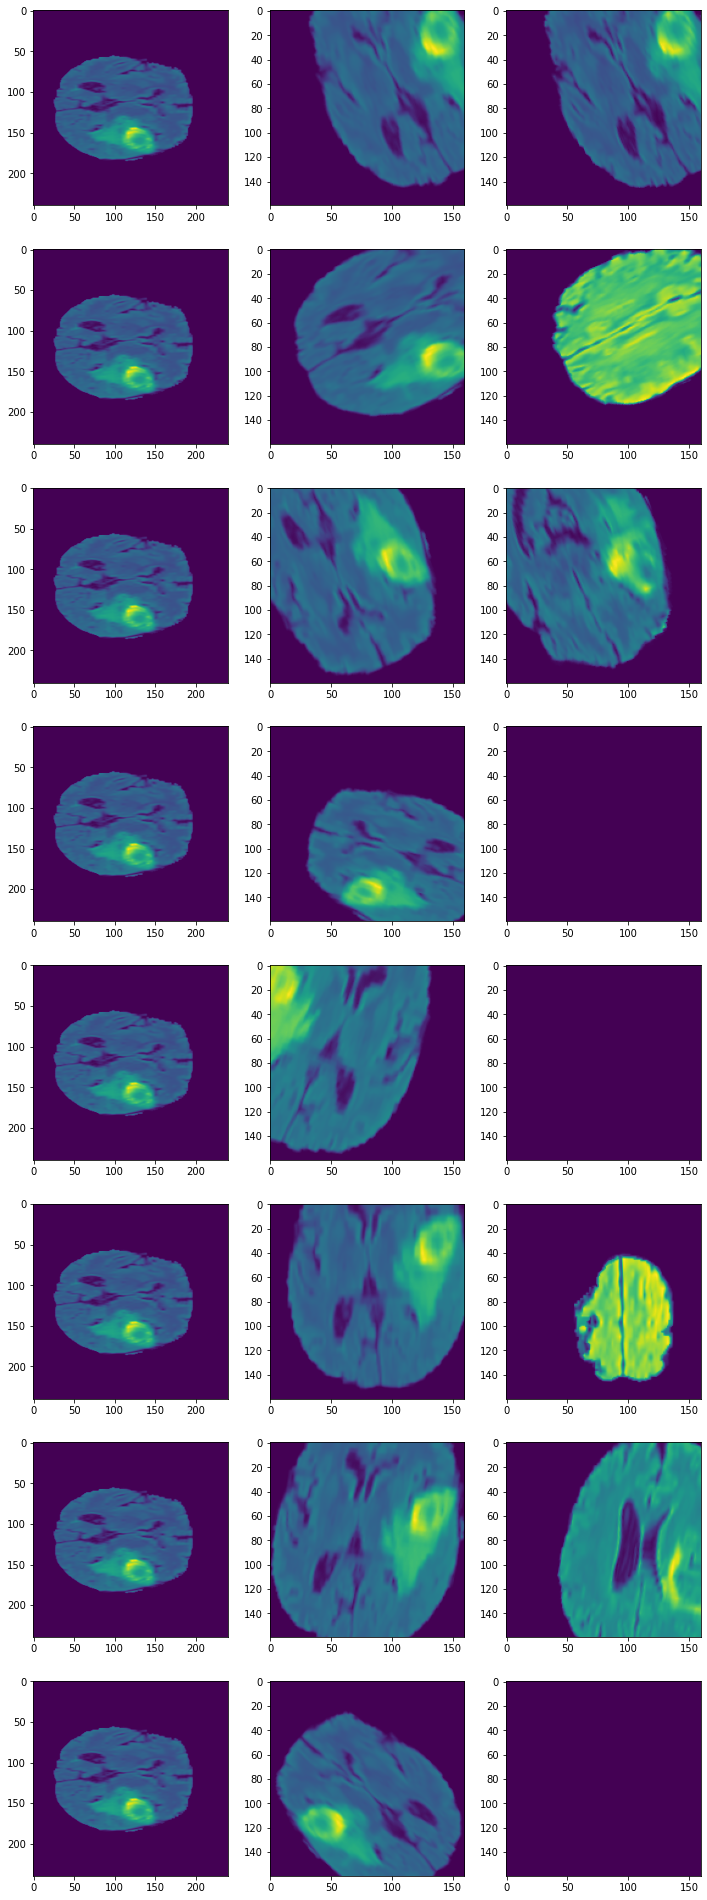

In [111]:
import time

import numpy as np
import nibabel as nib

def check_entropy_patch_last_pipeline():
    base_dir = '/home/ben/data/preprocessed/Task01_BrainTumour/orig'
    sample_str = 'BRATS_{}_{}.nii.gz'
    sample = '001'

    img = nib.load(os.path.join(base_dir, sample_str.format(sample, 'image')))
    lbl = nib.load(os.path.join(base_dir, sample_str.format(sample, 'label')))

    ddict = {'image': img.get_fdata(), 'label': lbl.get_fdata()}

    ddict['image'] = np.transpose(ddict['image'], axes=(3, 0, 1, 2))
    ddict['label'] = np.expand_dims(ddict['label'], axis=0)

    # print(ddict['image'].shape, ddict['label'].shape)

    tp = trad_pipeline_patch_last()
    lp = lazy_pipeline_patch_last(True)

    pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['image'])
    p_label_exts = find_mid_label(ddict['image'])
    # print("mid-label:", p_label_exts, tuple(p[1] - p[0] for p in p_label_exts))
    p_slice_x = slice(*sanitized_range_from_extents(p_label_exts[0][2], ddict['image'].shape[1], int(100 * 240 / 192)))
    p_slice_y = slice(*sanitized_range_from_extents(p_label_exts[1][2], ddict['image'].shape[2], int(100 * 240 / 192)))
    # print("extents:", p_slice_x, p_slice_y)

    num_samples = 8
    print(pre_first_z, pre_last_z, pre_mid_slice)
    vols = []
    results = []
    t_time = 0
    l_time = 0
    for i in range(num_samples):
        t_start = time.time()
        t_out = tp(ddict)
        t_time += time.time() - t_start
        # t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
        t_label_exts = find_mid_label(t_out['image'])
        print("t_label_exts:", t_label_exts)
        # print("mid-label:", t_label_exts, tuple(t[1] - t[0] for t in t_label_exts))
        t_slice_x = slice(*sanitized_range_from_extents(t_label_exts[0][2], t_out['image'].shape[1], 100))
        t_slice_y = slice(*sanitized_range_from_extents(t_label_exts[1][2], t_out['image'].shape[2], 100))
        print("extents:", t_slice_x, t_slice_y)
        # print(t_first_z, t_last_z, t_mid_slice)

        l_start = time.time()
        l_out = lp(ddict)
        l_time += time.time() - l_start
        # l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
        print("l_out:", l_out['image'].shape)
        l_label_exts = find_mid_label(l_out['image'])
        print("l_label_exts:", l_label_exts)
        # print("mid-label:", l_label_exts, tuple(l[1] - l[0] for l in l_label_exts))
        l_slice_x = slice(*sanitized_range_from_extents(l_label_exts[0][2], l_out['image'].shape[1], 100))
        l_slice_y = slice(*sanitized_range_from_extents(l_label_exts[1][2], l_out['image'].shape[2], 100))
        print("extents:", l_slice_x, l_slice_y)
        # print(l_first_z, l_last_z, l_mid_slice)
    
        vols.extend([ddict['image'][0, ...],
                     t_out['image'][1, ...],
                     l_out['image'][2, ...]])

        results.extend([ddict['image'][0, ..., p_label_exts[2][2]],
                        t_out['image'][0, ..., t_label_exts[2][2]],
                        l_out['image'][0, ..., l_label_exts[2][2]]])
        
    for i_r in range(8):
        ovol = vols[i_r * 3]
        tvol = vols[i_r * 3 + 1]
        lvol = vols[i_r * 3 + 2]
        print("ovol:", entropy(ovol),
              "tvol:", entropy(tvol),
              "lvol:", entropy(lvol))
            

    print(f"trad time: {t_time}, lazy time: {l_time}")
    plot_datas(results, 3, tight=True, size=10)
    
check_entropy_patch_last_pipeline()

In [ ]:
entropy_by_vol =np.asarray([
    [-0.6474312370041032, -0.5746644873304773],
    [-0.5820207582029828, -0.5154538747569736],
    [-0.6303136122149402, -0.5550618036447265],
    [-0.5225025523734912, -0.45886897465822146],
    [-0.7313230393674943, -0.6375291263882021],
    [-0.6009636467276522, -0.5386724596584971],
    [-0.658219893839086, -0.5855626119150623],
    [-0.5656265423842755, -0.481065145373282],
])

print(entropy_by_vol[:, 0])
print(entropy_by_vol[:, 1])
print("mean:", entropy_by_vol[:, 0].mean(), entropy_by_vol[:, 1].mean())
print("std:", entropy_by_vol[:, 0].std(), entropy_by_vol[:, 1].std())

## Whole pipeline

29 102 65
trad time: 7.79062032699585, lazy time: 5.2091522216796875


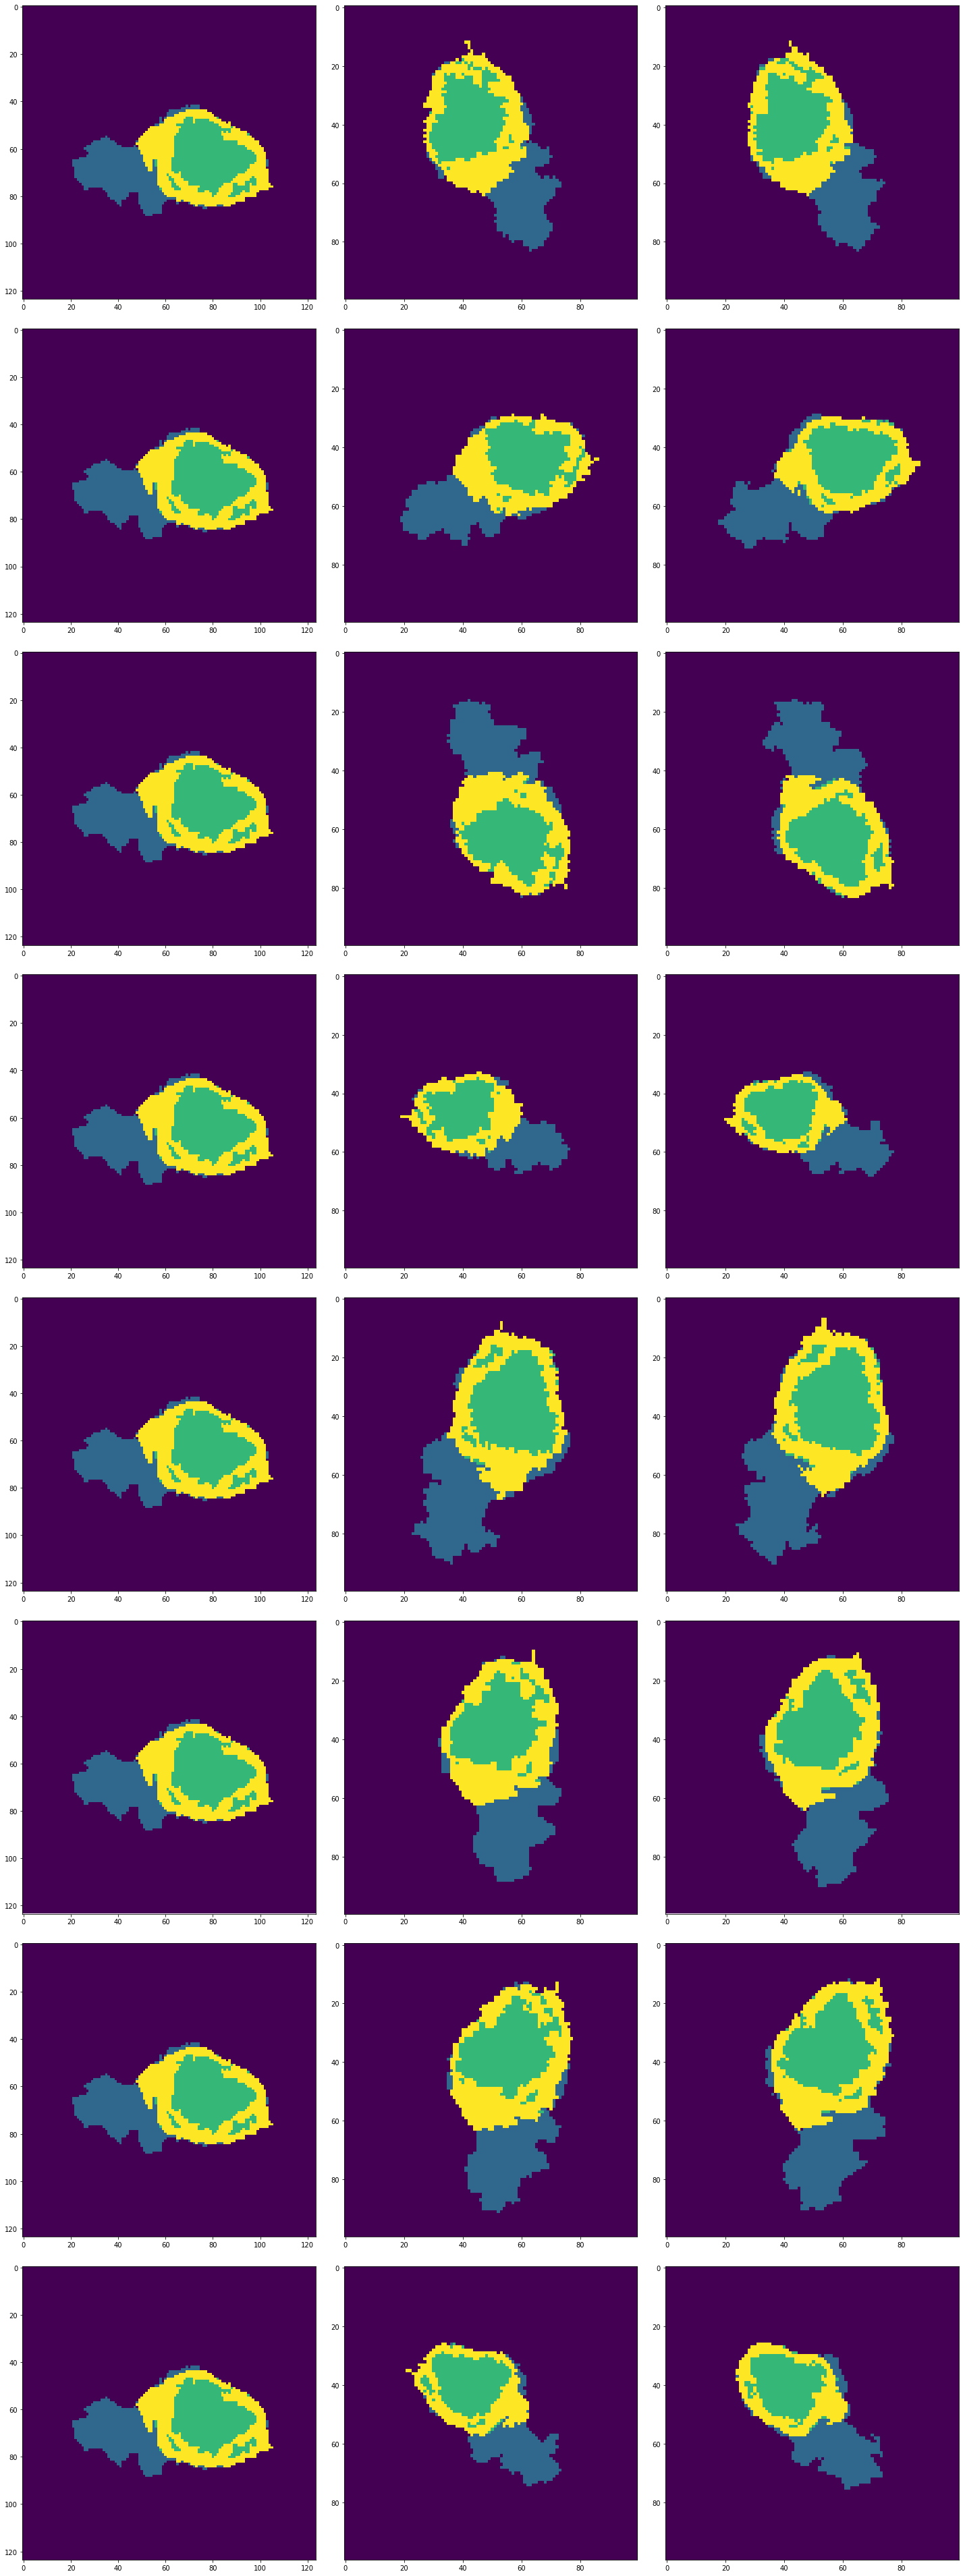

In [122]:
import time

import numpy as np
import nibabel as nib

def check_whole_pipeline_forward():
    base_dir = '/home/ben/data/preprocessed/Task01_BrainTumour/orig'
    sample_str = 'BRATS_{}_{}.nii.gz'
    sample = '001'

    img = nib.load(os.path.join(base_dir, sample_str.format(sample, 'image')))
    lbl = nib.load(os.path.join(base_dir, sample_str.format(sample, 'label')))

    ddict = {'image': img.get_fdata(), 'label': lbl.get_fdata()}

    ddict['image'] = np.transpose(ddict['image'], axes=(3, 0, 1, 2))
    ddict['label'] = np.expand_dims(ddict['label'], axis=0)

    # print(ddict['image'].shape, ddict['label'].shape)

    tp = trad_pipeline()
    lp = lazy_pipeline(True)

    pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['label'])
    p_label_exts = find_mid_label(ddict['label'])
    # print("mid-label:", p_label_exts, tuple(p[1] - p[0] for p in p_label_exts))
    p_slice_x = slice(*sanitized_range_from_extents(p_label_exts[0][2], ddict['label'].shape[1], int(100 * 240 / 192)))
    p_slice_y = slice(*sanitized_range_from_extents(p_label_exts[1][2], ddict['label'].shape[2], int(100 * 240 / 192)))
    # print("extents:", p_slice_x, p_slice_y)

    print(pre_first_z, pre_last_z, pre_mid_slice)
    results = []
    t_time = 0
    l_time = 0
    for i in range(8):
        t_start = time.time()
        t_out = tp(ddict)
        t_time += time.time() - t_start
        # t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
        t_label_exts = find_mid_label(t_out['label'])
        # print("mid-label:", t_label_exts, tuple(t[1] - t[0] for t in t_label_exts))
        t_slice_x = slice(*sanitized_range_from_extents(t_label_exts[0][2], t_out['label'].shape[1], 100))
        t_slice_y = slice(*sanitized_range_from_extents(t_label_exts[1][2], t_out['label'].shape[2], 100))
        # print("extents:", t_slice_x, t_slice_y)
        # print(t_first_z, t_last_z, t_mid_slice)

        l_start = time.time()
        l_out = lp(ddict)
        l_time += time.time() - l_start
        # l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
        l_label_exts = find_mid_label(l_out['label'])
        # print("mid-label:", l_label_exts, tuple(l[1] - l[0] for l in l_label_exts))
        l_slice_x = slice(*sanitized_range_from_extents(l_label_exts[0][2], l_out['label'].shape[1], 100))
        l_slice_y = slice(*sanitized_range_from_extents(l_label_exts[1][2], l_out['label'].shape[2], 100))
        # print("extents:", l_slice_x, l_slice_y)
        # print(l_first_z, l_last_z, l_mid_slice)
    
        results.extend([ddict['label'][0, p_slice_x, p_slice_y, pre_mid_slice],
                        t_out['label'][0, t_slice_x, t_slice_y, t_label_exts[2][2]],
                        l_out['label'][0, l_slice_x, l_slice_y, l_label_exts[2][2]]])

    print(f"trad time: {t_time}, lazy time: {l_time}")
    
    display_images['forward_pass_whole'] = copy.deepcopy(results[18:21])
    # plot_datas(results, 6)
    plot_datas(results, 3, tight=True)
    
check_whole_pipeline_forward()

## Patch first

lazy patch seed: 1540998321
lazy patch seed: 1540998321
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)
(240, 240, 155)
(80, 80, 0)
trad time: 2.914548873901367, lazy time: 2.028776168823242


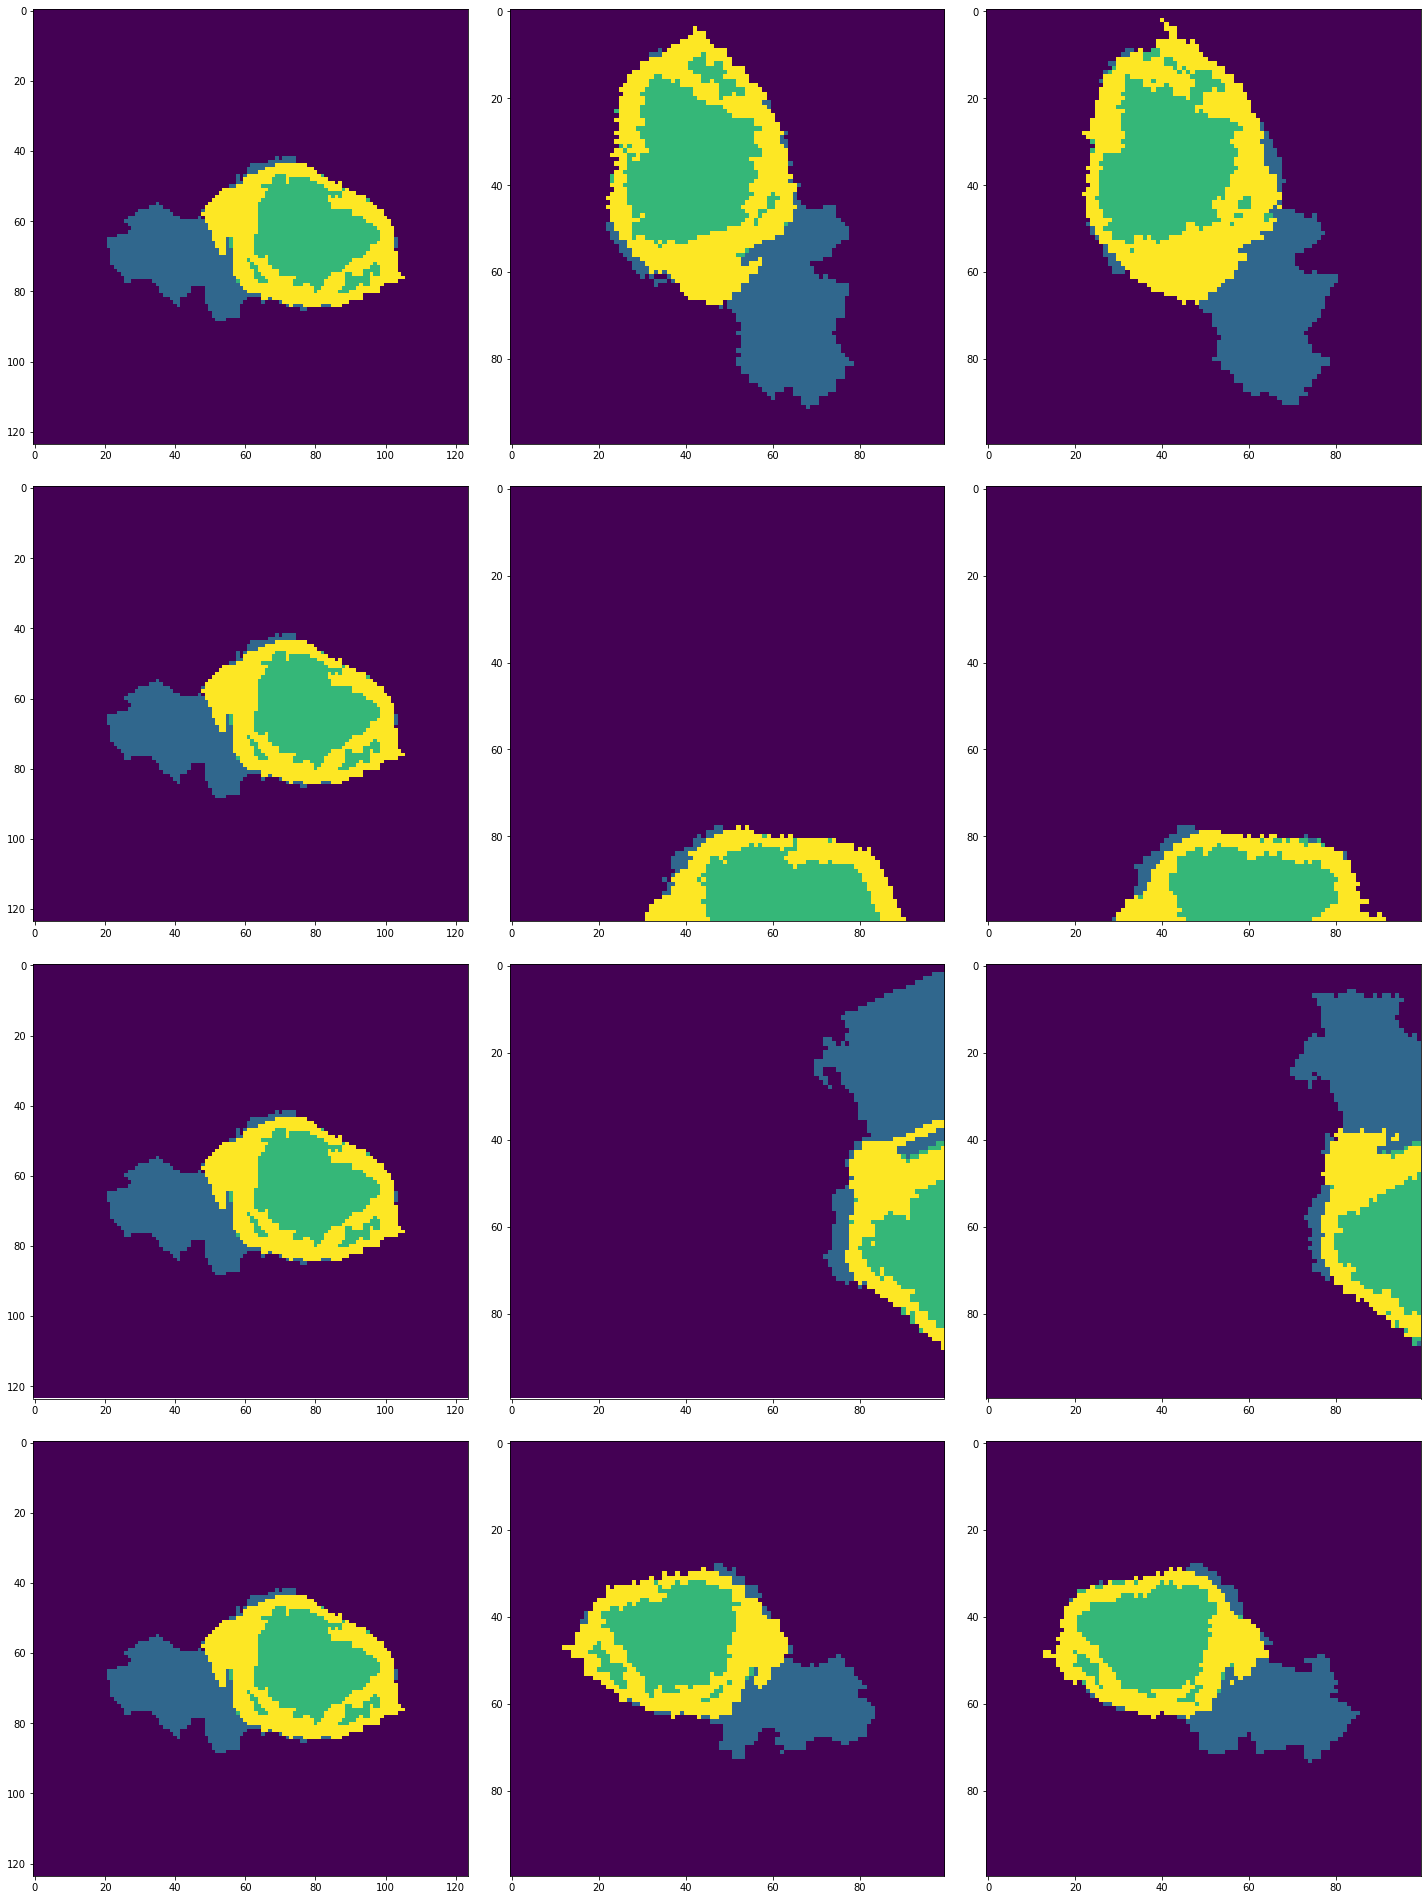

In [121]:
import time

import numpy as np
import nibabel as nib

def check_patch_first_pipeline_forward():
    base_dir = '/home/ben/data/preprocessed/Task01_BrainTumour/orig'
    sample_str = 'BRATS_{}_{}.nii.gz'
    sample = '001'
    
    iterations = 4

    img = nib.load(os.path.join(base_dir, sample_str.format(sample, 'image')))
    lbl = nib.load(os.path.join(base_dir, sample_str.format(sample, 'label')))

    ddict = {'image': img.get_fdata(), 'label': lbl.get_fdata()}

    ddict['image'] = np.transpose(ddict['image'], axes=(3, 0, 1, 2))
    ddict['label'] = np.expand_dims(ddict['label'], axis=0)

    # print(ddict['image'].shape, ddict['label'].shape)

    tp = trad_pipeline_patch_first()
    lp = lazy_pipeline_patch_first(True)

    pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['label'])
    p_label_exts = find_mid_label(ddict['label'])
    # print("mid-label:", p_label_exts, tuple(p[1] - p[0] for p in p_label_exts))
    p_slice_x = slice(*sanitized_range_from_extents(p_label_exts[0][2], ddict['label'].shape[1], int(100 * 240 / 192)))
    p_slice_y = slice(*sanitized_range_from_extents(p_label_exts[1][2], ddict['label'].shape[2], int(100 * 240 / 192)))
    # print("extents:", p_slice_x, p_slice_y)

#     pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['label'])
#     print(pre_first_z, pre_last_z, pre_mid_slice)
    results = []
    t_time = 0
    l_time = 0
    for i in range(iterations):
        t_start = time.time()
        t_out = tp(ddict)
        t_time += time.time() - t_start
        # t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
        t_label_exts = find_mid_label(t_out['label'])
        # print("mid-label:", t_label_exts, tuple(t[1] - t[0] for t in t_label_exts))
        t_slice_x = slice(*sanitized_range_from_extents(t_label_exts[0][2], t_out['label'].shape[1], 100))
        t_slice_y = slice(*sanitized_range_from_extents(t_label_exts[1][2], t_out['label'].shape[2], 100))
        # print("extents:", t_slice_x, t_slice_y)
        # print(t_first_z, t_last_z, t_mid_slice)
#         t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
#         print(t_first_z, t_last_z, t_mid_slice)
        l_start = time.time()
        l_out = lp(ddict)
        l_time += time.time() - l_start
        # l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
        l_label_exts = find_mid_label(l_out['label'])
        # print("mid-label:", l_label_exts, tuple(l[1] - l[0] for l in l_label_exts))
        l_slice_x = slice(*sanitized_range_from_extents(l_label_exts[0][2], l_out['label'].shape[1], 100))
        l_slice_y = slice(*sanitized_range_from_extents(l_label_exts[1][2], l_out['label'].shape[2], 100))
        # print("extents:", l_slice_x, l_slice_y)
        # print(l_first_z, l_last_z, l_mid_slice)
#         l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
#         print(l_first_z, l_last_z, l_mid_slice)

        results.extend([ddict['label'][0, p_slice_x, p_slice_y, pre_mid_slice],
                        t_out['label'][0, t_slice_x, t_slice_y, t_label_exts[2][2]],
                        l_out['label'][0, l_slice_x, l_slice_y, l_label_exts[2][2]]])
    print(f"trad time: {t_time}, lazy time: {l_time}")
    # plot_datas(results, 6)
    
    display_images['forward_pass_patch_first'] = copy.deepcopy(results[6:9])

    plot_datas(results, 3, tight=True)
    
check_patch_first_pipeline_forward()

## Patch last

lazy patch seed: 1540998321
lazy patch seed: 1540998321
29 102 65
torch.Size([1, 160, 160, 72])
t: 11 47 29
torch.Size([240, 240, 155])
(80, 80, 83)
l: 10 47 28
torch.Size([1, 160, 160, 72])
t: 12 46 29
torch.Size([240, 240, 155])
(80, 80, 83)
l: 0 15 7
torch.Size([1, 160, 160, 72])
t: 24 60 42
torch.Size([240, 240, 155])
(80, 80, 83)
l: 10 47 28
torch.Size([1, 160, 160, 72])
t: 26 54 40
torch.Size([240, 240, 155])
(80, 80, 83)
l: 0 72 36
trad time: 5.265597105026245, lazy time: 1.9595487117767334


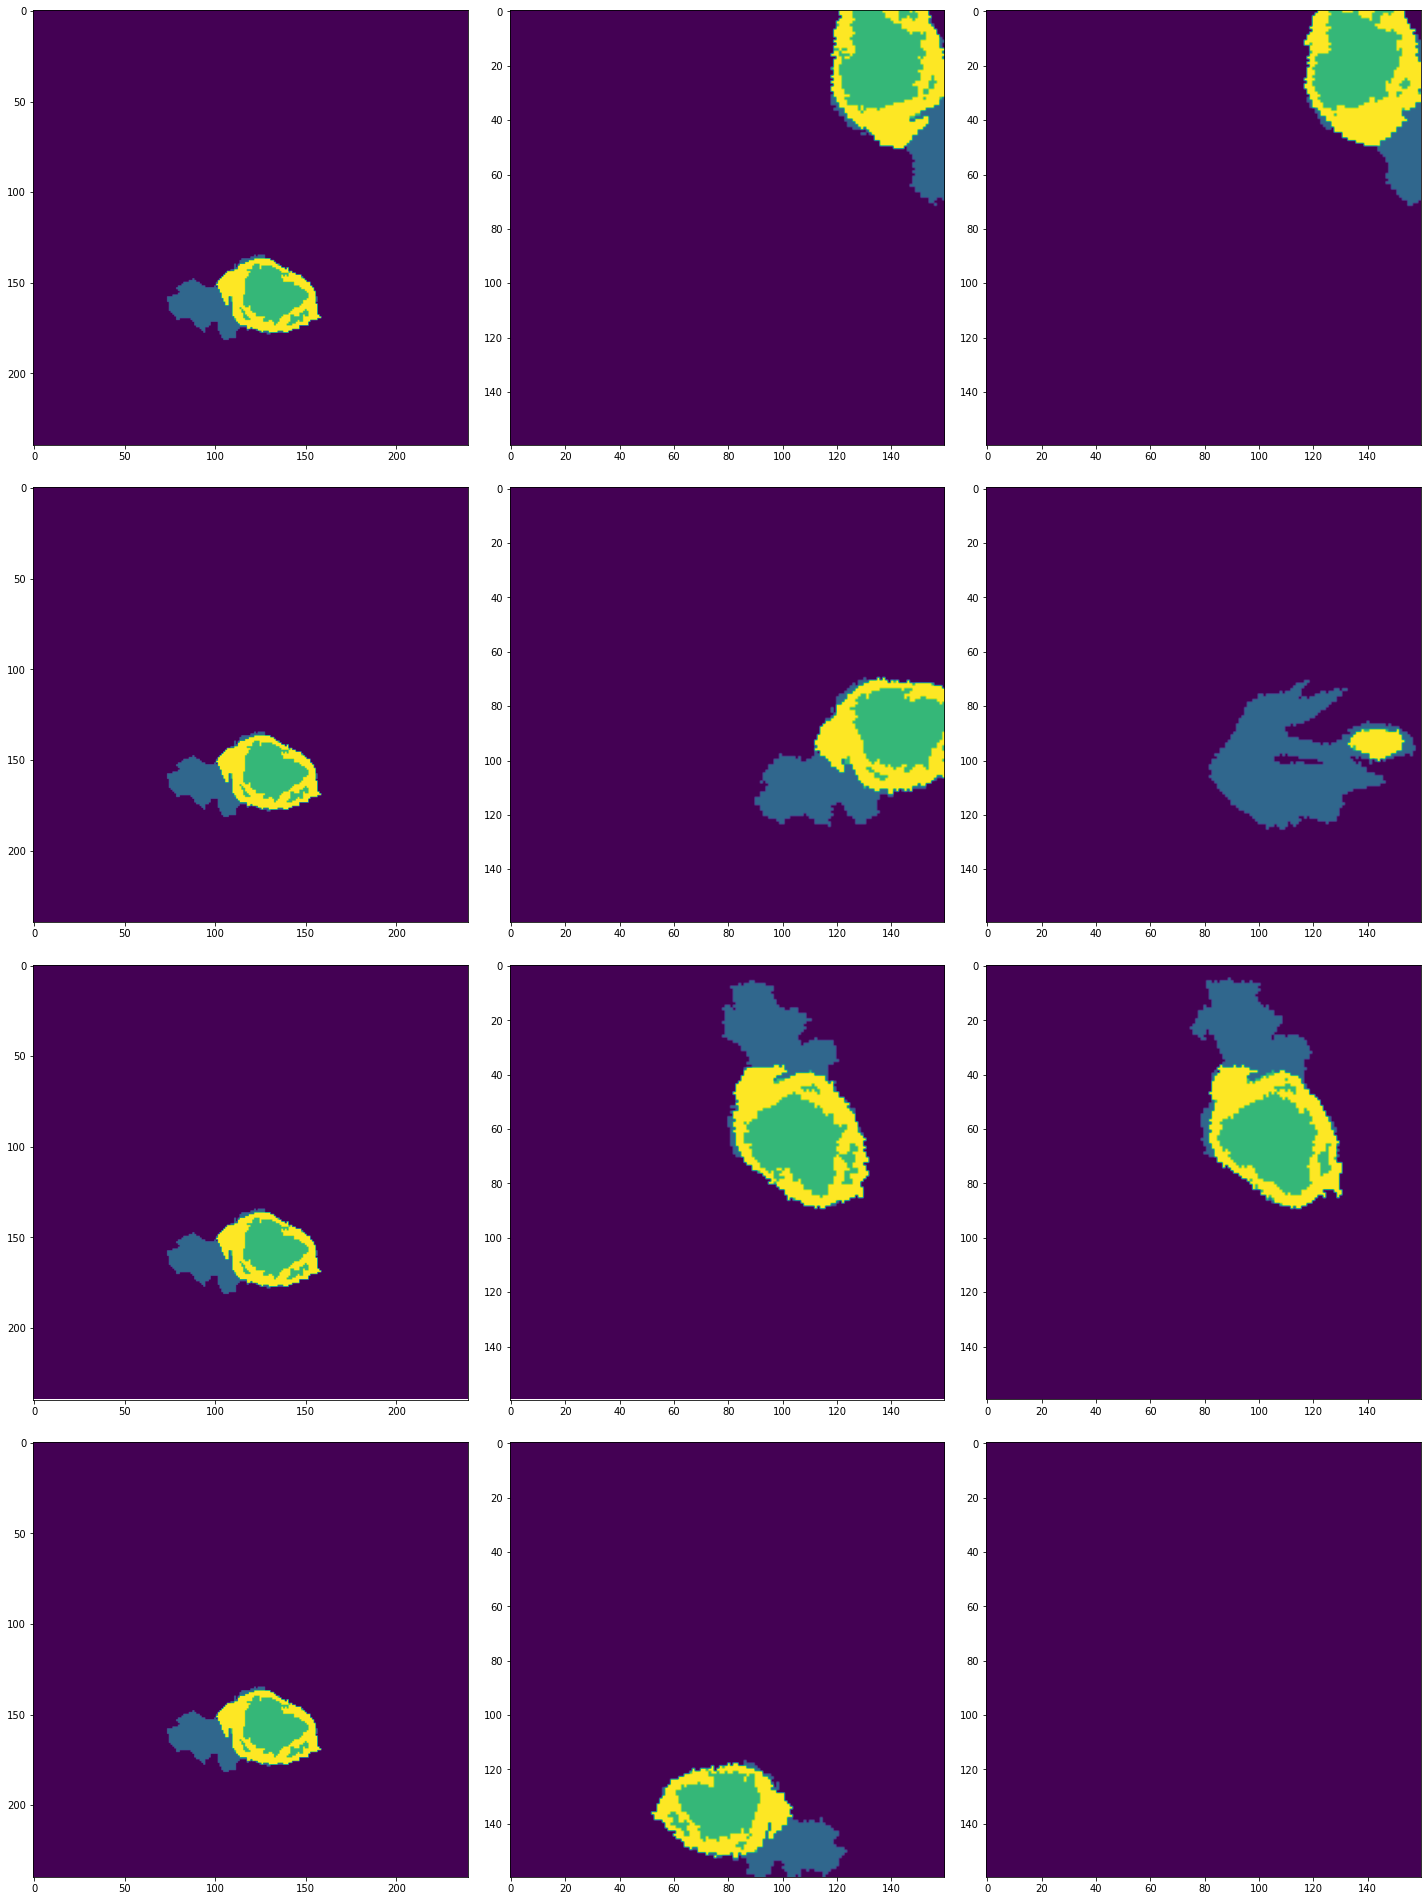

In [107]:
import time

import numpy as np
import nibabel as nib

def check_patch_first_pipeline_forward():
    base_dir = '/home/ben/data/preprocessed/Task01_BrainTumour/orig'
    sample_str = 'BRATS_{}_{}.nii.gz'
    sample = '001'
    
    iterations = 4

    img = nib.load(os.path.join(base_dir, sample_str.format(sample, 'image')))
    lbl = nib.load(os.path.join(base_dir, sample_str.format(sample, 'label')))

    ddict = {'image': img.get_fdata(), 'label': lbl.get_fdata()}

    ddict['image'] = np.transpose(ddict['image'], axes=(3, 0, 1, 2))
    ddict['label'] = np.expand_dims(ddict['label'], axis=0)

    # print(ddict['image'].shape, ddict['label'].shape)

    tp = trad_pipeline_patch_last()
    lp = lazy_pipeline_patch_last(True)

#     pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['label'])
#     p_label_exts = find_mid_label(ddict['label'])
#     # print("mid-label:", p_label_exts, tuple(p[1] - p[0] for p in p_label_exts))
#     p_slice_x = slice(*sanitized_range_from_extents(p_label_exts[0][2], ddict['label'].shape[1], int(100 * 240 / 192)))
#     p_slice_y = slice(*sanitized_range_from_extents(p_label_exts[1][2], ddict['label'].shape[2], int(100 * 240 / 192)))
#     # print("extents:", p_slice_x, p_slice_y)

# #     pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['label'])
# #     print(pre_first_z, pre_last_z, pre_mid_slice)
#     results = []
#     t_time = 0
#     l_time = 0
#     for i in range(iterations):
#         t_start = time.time()
#         t_out = tp(ddict)
#         t_time += time.time() - t_start
#         # t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
#         t_label_exts = find_mid_label(t_out['label'])
#         print("mid-label:", t_label_exts, tuple(t[1] - t[0] for t in t_label_exts))
#         t_slice_x = slice(*sanitized_range_from_extents(t_label_exts[0][2], t_out['label'].shape[1], 100))
#         t_slice_y = slice(*sanitized_range_from_extents(t_label_exts[1][2], t_out['label'].shape[2], 100))
#         # print("extents:", t_slice_x, t_slice_y)
#         # print(t_first_z, t_last_z, t_mid_slice)
# #         t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
# #         print(t_first_z, t_last_z, t_mid_slice)
#         l_start = time.time()
#         l_out = lp(ddict)
#         l_time += time.time() - l_start
#         # l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
#         l_label_exts = find_mid_label(l_out['label'])
#         print("mid-label:", l_label_exts, tuple(l[1] - l[0] for l in l_label_exts))
#         l_slice_x = slice(*sanitized_range_from_extents(l_label_exts[0][2], l_out['label'].shape[1], 100))
#         l_slice_y = slice(*sanitized_range_from_extents(l_label_exts[1][2], l_out['label'].shape[2], 100))
#         # print("extents:", l_slice_x, l_slice_y)
#         # print(l_first_z, l_last_z, l_mid_slice)
# #         l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
# #         print(l_first_z, l_last_z, l_mid_slice)

#         results.extend([ddict['label'][0, p_slice_x, p_slice_y, pre_mid_slice],
#                         t_out['label'][0, t_slice_x, t_slice_y, t_label_exts[2][2]],
#                         l_out['label'][0, l_slice_x, l_slice_y, l_label_exts[2][2]]])

    pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['label'])
    print(pre_first_z, pre_last_z, pre_mid_slice)
    results = []
    t_time = 0
    l_time = 0
    for i in range(iterations):
        t_start = time.time()
        t_out = tp(ddict)
        t_time += time.time() - t_start
        print(t_out['label'].shape)
        t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
        print("t:", t_first_z, t_last_z, t_mid_slice)
        l_start = time.time()
        l_out = lp(ddict)
        l_time += time.time() - l_start
        l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
        print("l:", l_first_z, l_last_z, l_mid_slice)

    #     results.extend([ddict['image'][0, ..., pre_mid_slice], ddict['label'][0, ..., pre_mid_slice],
    #                     t_out['image'][0, ..., post_mid_slice], t_out['label'][0, ..., post_mid_slice],
    #                     l_out['image'][0, ..., post_mid_slice], l_out['label'][0, ..., post_mid_slice]])
        results.extend([ddict['label'][0, ..., pre_mid_slice],
                        t_out['label'][0, ..., t_mid_slice],
                        l_out['label'][0, ..., l_mid_slice]])
    print(f"trad time: {t_time}, lazy time: {l_time}")
    # plot_datas(results, 6)
    plot_datas(results, 3, tight=True)
    
check_patch_first_pipeline_forward()

In [3]:
def roundtrip_experiment():
    base_dir = '/home/ben/data/preprocessed/Task01_BrainTumour/orig'
    sample_str = 'BRATS_{}_{}.nii.gz'
    sample = '001'

    img = nib.load(os.path.join(base_dir, sample_str.format(sample, 'image')))
    lbl = nib.load(os.path.join(base_dir, sample_str.format(sample, 'label')))

    ddict = {'image': img.get_fdata(), 'label': lbl.get_fdata()}

    ddict['image'] = np.transpose(ddict['image'], axes=(3, 0, 1, 2))
    ddict['label'] = np.expand_dims(ddict['label'], axis=0)

    # print(ddict['image'].shape, ddict['label'].shape)

    tp = trad_pipeline()
    lp = lazy_pipeline(True)
    # before = []
    # after = []
    print("tp:", tp)
    print("lp:", lp)
    
    tinverter = Invert(transform=tp, nearest_interp=True, device="cpu", post_func=torch.as_tensor)
    linverter = Invert(transform=lp, nearest_interp=True, device="cpu", post_func=torch.as_tensor)
    pre_first_z, pre_last_z, pre_mid_slice = find_mid_label_z(ddict['label'])
    print(pre_first_z, pre_last_z, pre_mid_slice)
    # pre_mid_slice=77
    # post_mid_slice=36
    results = []
    for i in range(8):
        t_out = tp(ddict)
        t_inv = tinverter(t_out)
#         t_first_z, t_last_z, t_mid_slice = find_mid_label_z(t_out['label'])
#         print(t_first_z, t_last_z, t_mid_slice)
        l_out = lp(ddict)
        l_inv = linverter(l_out)
#         l_first_z, l_last_z, l_mid_slice = find_mid_label_z(l_out['label'])
#         print(l_first_z, l_last_z, l_mid_slice)

    #     results.extend([ddict['image'][0, ..., pre_mid_slice], ddict['label'][0, ..., pre_mid_slice],
    #                     t_out['image'][0, ..., post_mid_slice], t_out['label'][0, ..., post_mid_slice],
    #                     l_out['image'][0, ..., post_mid_slice], l_out['label'][0, ..., post_mid_slice]])
        results.extend([ddict['image'][0, ..., pre_mid_slice],
                        t_inv['image'][0, ..., pre_mid_slice],
                        l_inv['image'][0, ..., pre_mid_slice]])

    # plot_datas(results, 6)
    plot_datas(results, 3, tight=True)
    
roundtrip_experiment()



NameError: name 'nib' is not defined

# RandGridDistortion

In [ ]:
def do_rand_grid_distortion():
    data = get_img((64, 64))
    hival = data.max()
    data[0,7:9,7:9] = hival + 64
    data[0,15:17,:] = hival + 128
    data[0,0,:] = hival + 192
    data[0,:,0] = hival + 256
    print(data.shape)
    
    r1 = RandGridDistortion(9, 1.0, (-0.1, 0.1), padding_mode="zeros")
    result1 = r1(data)
    
    r2 = Rand2DElastic((4, 4), (-0.1, 0.1), 1.0, padding_mode="zeros")
    result2 = r2(data)
    
    plot_datas([data, result1, result2])

do_rand_grid_distortion()

# Inversion test - whole images

['/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_001_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_002_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_003_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_004_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_005_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_006_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_007_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_008_label.nii.gz']
trad_pipeline_label_only
lazy_pipeline_label_only
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
l 1 0.9176151746895873
(array([0., 1., 2., 3.], dtype=float32), array([261255

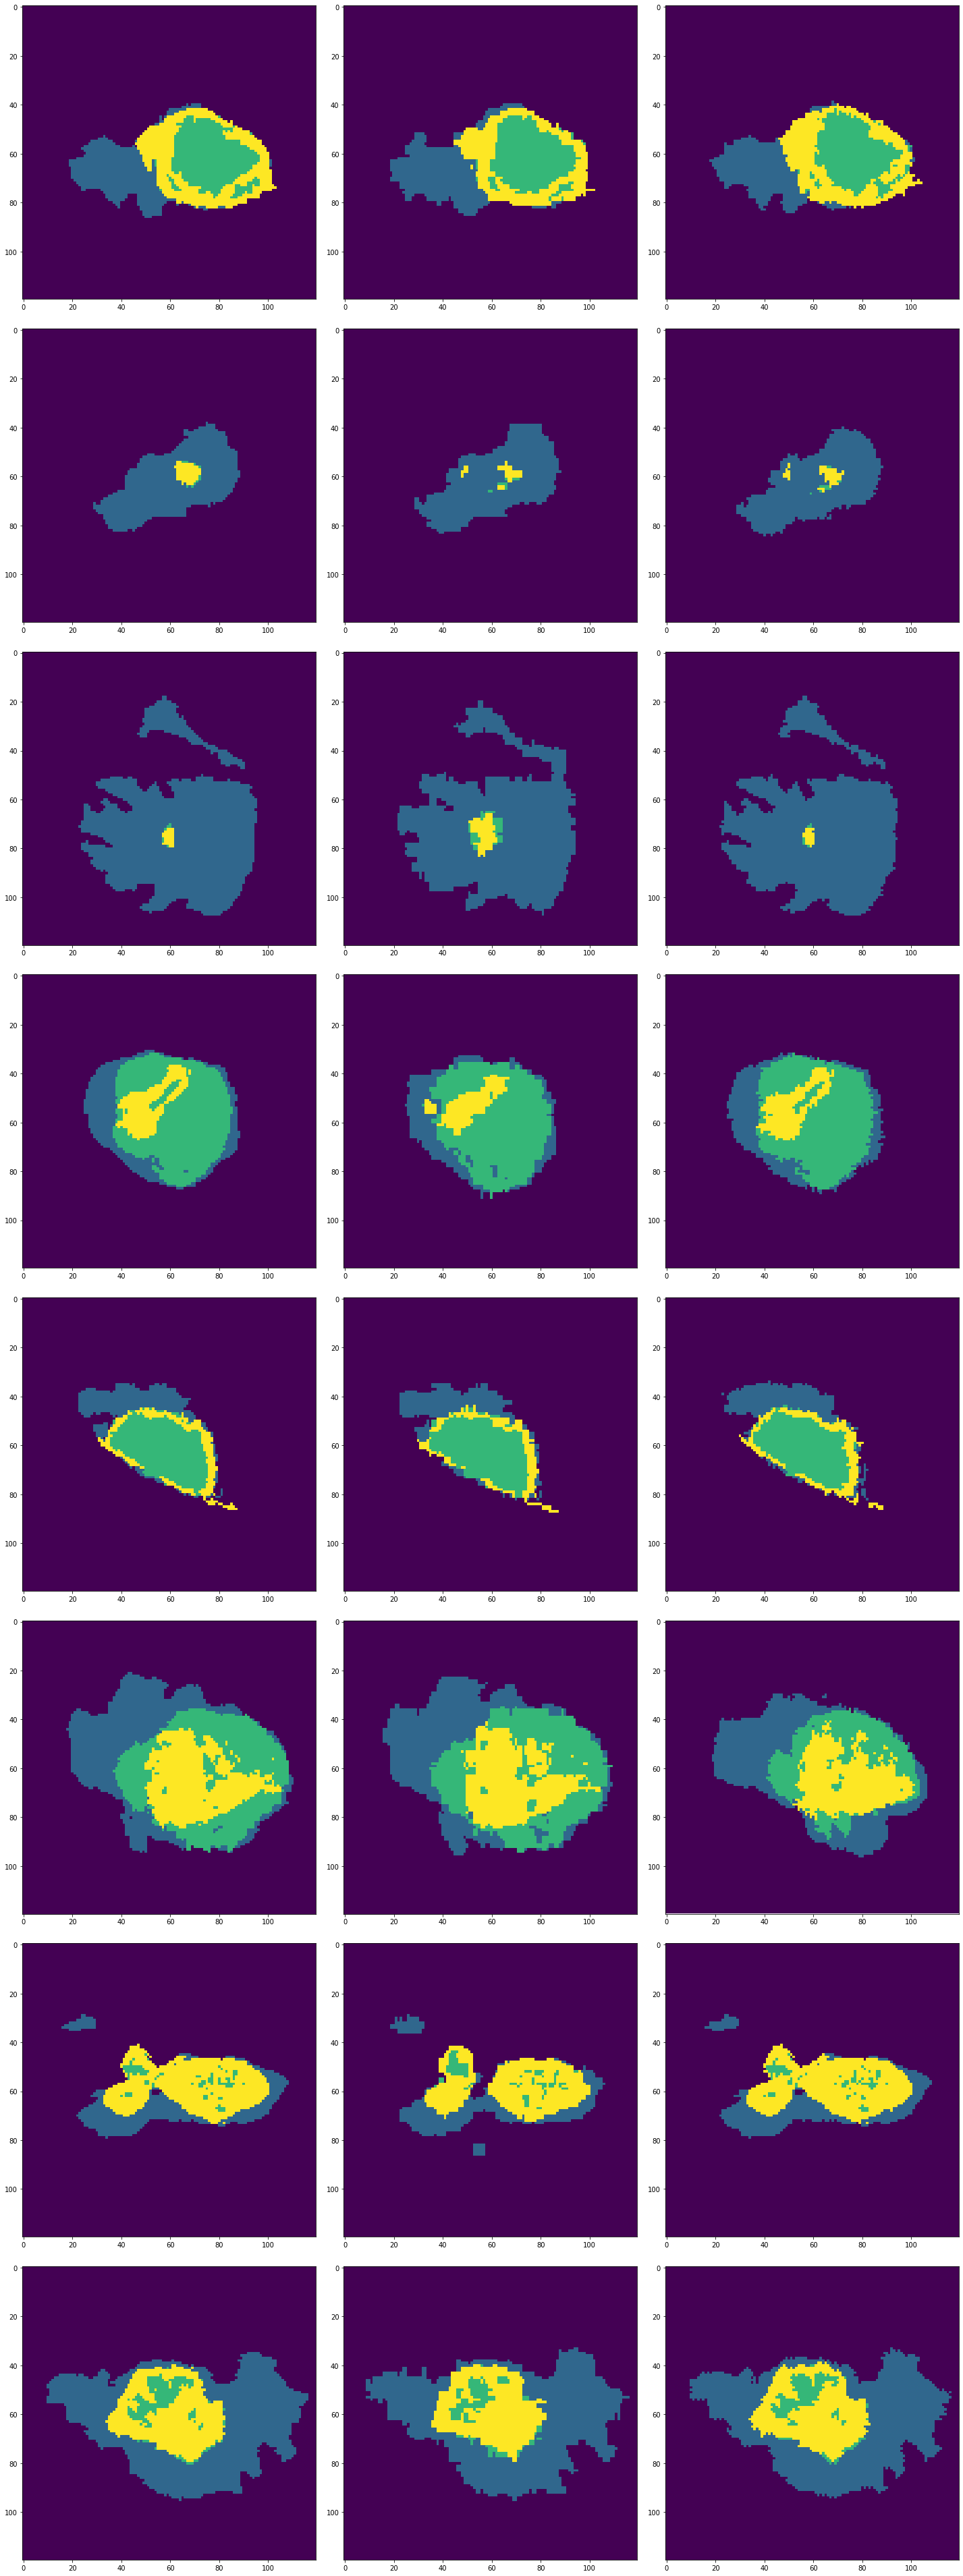

In [127]:
def test_invert():
    import sys
    from copy import deepcopy
    from monai.utils import set_determinism
    from tests.utils import assert_allclose, make_nifti_image    
    from monai.data import DataLoader, Dataset, MetaTensor, create_test_image_3d, decollate_batch
    from monai.transforms import (
        CastToType,
        Compose,
        EnsureChannelFirst,
        Invert,
        LoadImage,
        Orientation,
        RandAffine,
        RandAxisFlip,
        RandFlip,
        RandRotate,
        RandRotate90,
        RandZoom,
        ResizeWithPadOrCrop,
        Spacing,
    )


    mode = 'nearest'
    set_determinism(seed=0)
    # im_fname = make_nifti_image(create_test_image_3d(101, 100, 107, noise_max=100)[1])  # label image, discrete
#     data = [im_fname for _ in range(12)]

    data = ['/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_001_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_002_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_003_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_004_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_005_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_006_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_007_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_008_label.nii.gz',
           ]
    num_rows = len(data)
    print(data)
    lazy = True
    base_images = Compose(
        [
            LoadImage(image_only=True),
            EnsureChannelFirst(),
        ]
    )
    
    transform_old = trad_pipeline_label_only()
    transform_new = lazy_pipeline_label_only()
    
    results = [None for _ in range(num_rows * 3)]

    for i_tx, tx in enumerate([transform_old, transform_new]):
        # num workers = 0 for mac or gpu transforms
        num_workers = 0 if sys.platform != "linux" or torch.cuda.is_available() else 2
        base_dataset = Dataset(data, transform=base_images)
        base_loader = DataLoader(base_dataset, suppress_rng=True, num_workers=num_workers, batch_size=1)

        dataset = Dataset(data, transform=tx)
        loader = DataLoader(dataset, suppress_rng=True, num_workers=num_workers, batch_size=1)
        inverter = Invert(transform=tx, nearest_interp=True, device="cpu", post_func=torch.as_tensor)

        for i_d, d in enumerate(base_loader):
            d = decollate_batch(d)
            for item in d:
                print(item.shape)
                if i_tx == 0:
                    results[i_d * 3] = item

        for i_d, d in enumerate(loader):
            d = decollate_batch(d)
            for item in d:
                print(np.unique(item, return_counts=True))
                orig = deepcopy(item)
                i = inverter(item)
                print(item.shape, i.shape)
                results[i_d * 3 + i_tx + 1] = i
        # check labels match
        reverted = i.detach().cpu().numpy().astype(np.int32)
        original = LoadImage(image_only=True)(data[-1])
        n_good = np.sum(np.isclose(reverted, original.numpy(), atol=1e-3))
        reverted_name = i.meta["filename_or_obj"]
        original_name = original.meta["filename_or_obj"]
        print("invert diff", reverted.size - n_good)
        set_determinism(seed=None)

    dl = DiceLoss(reduction="none")
    for r in range(num_rows):
        r0 = results[r*3]
        r0h = torch.nn.functional.one_hot(r0.long())
        r0h = torch.squeeze(r0h, 0).permute(3, 0, 1, 2)
        r1 = results[r*3+1]
        r1h = torch.nn.functional.one_hot(r1.long())
        r1h = torch.squeeze(r1h, 0).permute(3, 0, 1, 2)
        print(r0h.shape, r1h.shape)
        r2 = results[r*3+2]
        r2h = torch.nn.functional.one_hot(r2.long())
        r2h = torch.squeeze(r2h, 0).permute(3, 0, 1, 2)

        print(r0h.shape)
        dl1 = dl(r0h, r1h).mean(dim=(1,2,3))
        dl2 = dl(r0h, r2h).mean(dim=(1,2,3))
        
        print(1 - dl1, 1 - dl2)

    clipped_results = list()
    for r in results:
        r_label_exts = find_mid_label(r)
        # print("mid-label:", t_label_exts, tuple(t[1] - t[0] for t in t_label_exts))
        r_slice_x = slice(*sanitized_range_from_extents(r_label_exts[0][2], r.shape[1], 120))
        r_slice_y = slice(*sanitized_range_from_extents(r_label_exts[1][2], r.shape[2], 120))

        clipped_results.append(r[0, r_slice_x, r_slice_y, r_label_exts[2][2]])

    display_images['round_trip_whole'] = copy.deepcopy(clipped_results[21:24])

    plot_datas(clipped_results, 3, tight=True)
#     plot_datas([r[0, ..., find_mid_label_z(r)[2]] for r in results], 3, tight=True)
    
test_invert()

In [10]:
trad_class_losses = np.asarray([
    [0.9976, 0.8967, 0.9199, 0.9024],
    [0.9985, 0.9153, 0.8667, 0.9218],
    [0.9975, 0.8710, 0.8469, 0.9291],
    [0.9988, 0.8790, 0.9178, 0.9098],
    [0.9994, 0.9362, 0.9530, 0.9339],
    [0.9968, 0.8567, 0.8951, 0.8981],
    [0.9981, 0.8157, 0.8726, 0.8884],
    [0.9977, 0.8998, 0.8801, 0.9043]
])

lazy_class_losses = np.asarray([
    [0.9996, 0.9714, 0.9692, 0.9769],
    [0.9997, 0.9795, 0.9274, 0.9832],
    [0.9992, 0.9609, 0.9249, 0.9806],
    [0.9996, 0.9470, 0.9736, 0.9507],
    [0.9997, 0.9692, 0.9736, 0.9690],
    [0.9995, 0.9695, 0.9692, 0.9774],
    [0.9997, 0.9547, 0.9657, 0.9825],
    [0.9992, 0.9564, 0.9441, 0.9612]
])

print(trad_class_losses.shape)
print(lazy_class_losses.shape)
print(trad_class_losses.mean(axis=0), trad_class_losses.std(axis=0))
print(lazy_class_losses.mean(axis=0), trad_class_losses.std(axis=0))


(8, 4)
(8, 4)
[0.99805   0.8838    0.8940125 0.910975 ] [0.00077298 0.03485563 0.03227679 0.01485814]
[0.999525  0.963575  0.9559625 0.9726875] [0.00019843 0.00996064 0.01932893 0.01083033]


['/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_001_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_002_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_003_label.nii.gz', '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_004_label.nii.gz']
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])
(array([0, 1, 2, 3], dtype=uint8), array([8147770,   17491,   15387,    6552]))
torch.Size([1, 200, 172, 238]) torch.Size([1, 240, 240, 155])
(array([0, 1, 2, 3], dtype=uint8), array([8166781,   16942,    1560,    1917]))
torch.Size([1, 200, 172, 238]) torch.Size([1, 240, 240, 155])
(array([0, 1, 2, 3], dtype=uint8), array([8129718,   48008,    3521,    5953]))
torch.Size([1, 200, 172, 238]) torch.Size([1, 240, 240, 155])
(array([0, 1, 2, 3], dtype=uint8), array([8144203,   17076,   22148,    3773]))
torch.Size([1, 200, 172, 238]) torch.Size([1, 240, 240, 1

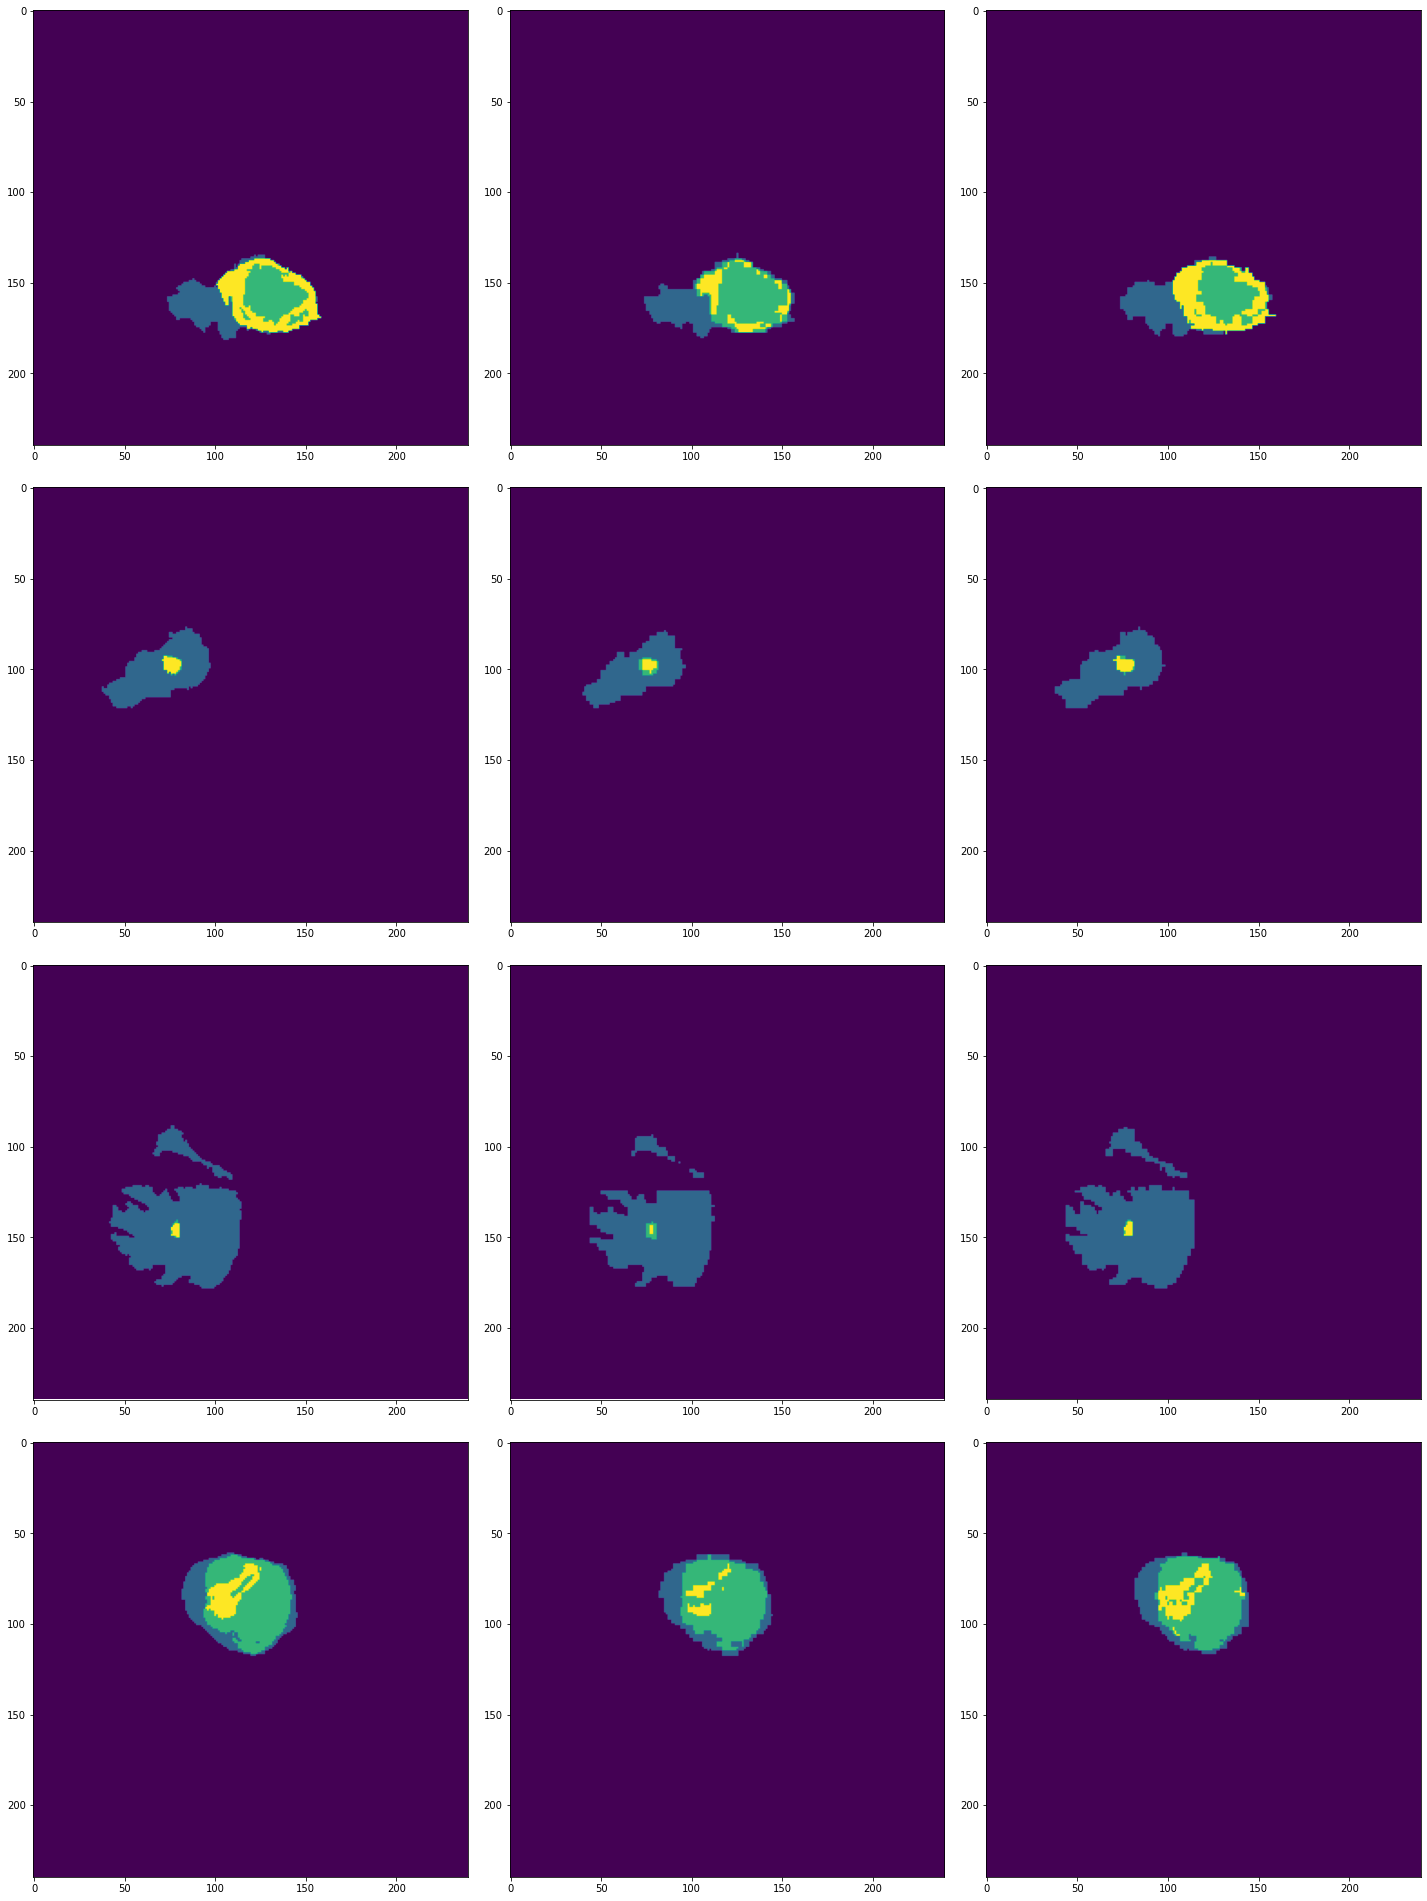

In [81]:
def test_invert():
    import sys
    from copy import deepcopy
    from monai.utils import set_determinism
    from tests.utils import assert_allclose, make_nifti_image    
    from monai.data import DataLoader, Dataset, MetaTensor, create_test_image_3d, decollate_batch
    from monai.transforms import (
        CastToType,
        Compose,
        EnsureChannelFirst,
        Invert,
        LoadImage,
        Orientation,
        RandAffine,
        RandAxisFlip,
        RandFlip,
        RandRotate,
        RandRotate90,
        RandZoom,
        ResizeWithPadOrCrop,
        Spacing,
    )

    num_rows = 4

    mode = 'nearest'
    set_determinism(seed=0)
    # im_fname = make_nifti_image(create_test_image_3d(101, 100, 107, noise_max=100)[1])  # label image, discrete
#     data = [im_fname for _ in range(12)]

    data = ['/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_001_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_002_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_003_label.nii.gz',
            '/home/ben/data/preprocessed/Task01_BrainTumour/orig/BRATS_004_label.nii.gz']

    print(data)
    lazy = True
    base_images = Compose(
        [
            LoadImage(image_only=True),
            EnsureChannelFirst(),
        ]
    )
    transform_old = Compose(
        [
            LoadImage(image_only=True),
            EnsureChannelFirst(),
            # Orientation("RPS"),
            old.Spacing(pixdim=(1.2, 1.01, 0.9), mode=mode, dtype=np.float32),
            old.Flip(spatial_axis=[1, 2]),
            old.Rotate90(spatial_axes=(1, 2)),
            old.Zoom(zoom=0.75, keep_size=True),
            old.Rotate(angle=(np.pi, 0, 0), mode=mode, align_corners=True, dtype=np.float64),
            # RandAffine(prob=0.5, rotate_range=np.pi, mode="nearest"),
            # ResizeWithPadOrCrop(100),
            CastToType(dtype=torch.uint8),
        ]
    )
    transform_new = Compose(
        [
            LoadImage(image_only=True),
            EnsureChannelFirst(),
            # Orientation("RPS"),
            Spacing(pixdim=(1.2, 1.01, 0.9), mode=mode, dtype=np.float32, lazy_evaluation=lazy),
            Flip(spatial_axis=[1, 2], lazy_evaluation=lazy),
            Rotate90(spatial_axes=(1, 2), lazy_evaluation=lazy),
            Zoom(zoom=0.75, keep_size=True, lazy_evaluation=lazy),
            Rotate(angle=(0, 0, np.pi), mode=mode, align_corners=True, dtype=np.float64,
                   lazy_evaluation=lazy),
            # RandAffine(prob=0.5, rotate_range=np.pi, mode="nearest"),
            # ResizeWithPadOrCrop(100),
            CastToType(dtype=torch.uint8),
        ]
    )
    # print(transform._forward_transforms)
    
    # print("loader length =", len(loader))
    # fig, ax = plt.subplots(12, 3, figsize=(12, 48))
    
    results = [None for _ in range(num_rows * 3)]

    for i_tx, tx in enumerate([transform_old, transform_new]):
        # num workers = 0 for mac or gpu transforms
        num_workers = 0 if sys.platform != "linux" or torch.cuda.is_available() else 2
        base_dataset = Dataset(data, transform=base_images)
        base_loader = DataLoader(base_dataset, num_workers=num_workers, batch_size=1)

        dataset = Dataset(data, transform=tx)
        # self.assertIsInstance(transform.inverse(dataset[0]), MetaTensor)
        loader = DataLoader(dataset, num_workers=num_workers, batch_size=1)
        inverter = Invert(transform=tx, nearest_interp=True, device="cpu", post_func=torch.as_tensor)

        for i_d, d in enumerate(base_loader):
            d = decollate_batch(d)
            for item in d:
                print(item.shape)
                if i_tx == 0:
                    # results[i_d * 3] = item[0, ..., item.shape[-1] // 2]
                    results[i_d * 3] = item

        for i_d, d in enumerate(loader):
            d = decollate_batch(d)
            for item in d:
                print(np.unique(item, return_counts=True))
                orig = deepcopy(item)
                i = inverter(item)
                print(item.shape, i.shape)
                # results[i_d * 3 + i_tx + 1] = i[0, ..., i.shape[-1] // 2]
                results[i_d * 3 + i_tx + 1] = i
        # check labels match
        reverted = i.detach().cpu().numpy().astype(np.int32)
        original = LoadImage(image_only=True)(data[-1])
        n_good = np.sum(np.isclose(reverted, original.numpy(), atol=1e-3))
        reverted_name = i.meta["filename_or_obj"]
        original_name = original.meta["filename_or_obj"]
        # self.assertEqual(reverted_name, original_name)
        print("invert diff", reverted.size - n_good)
        # self.assertTrue((reverted.size - n_good) < 300000, f"diff. {reverted.size - n_good}")
        set_determinism(seed=None)

    # print(['None' if r is None else r.shape for r in results])
    dl = DiceLoss(reduction="none")
    for r in range(num_rows):
        r0 = results[r*3]
        r0h = torch.nn.functional.one_hot(r0.long())
        r0h = torch.squeeze(r0h, 0).permute(3, 0, 1, 2)
        r1 = results[r*3+1]
        r1h = torch.nn.functional.one_hot(r1.long())
        r1h = torch.squeeze(r1h, 0).permute(3, 0, 1, 2)
        print(r0h.shape, r1h.shape)
        r2 = results[r*3+2]
        r2h = torch.nn.functional.one_hot(r2.long())
        r2h = torch.squeeze(r2h, 0).permute(3, 0, 1, 2)

        print(r0h.shape)
        dl1 = dl(r0h, r1h).mean(dim=(1,2,3))
        dl2 = dl(r0h, r2h).mean(dim=(1,2,3))
        
        print(1 - dl1, 1 - dl2)

    plot_datas([r[0, ..., find_mid_label_z(r)[2]] for r in results], 3, tight=True)
    
test_invert()

torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99]) torch.Size([1, 101, 100, 107])
torch.Size([1, 84, 119, 99])

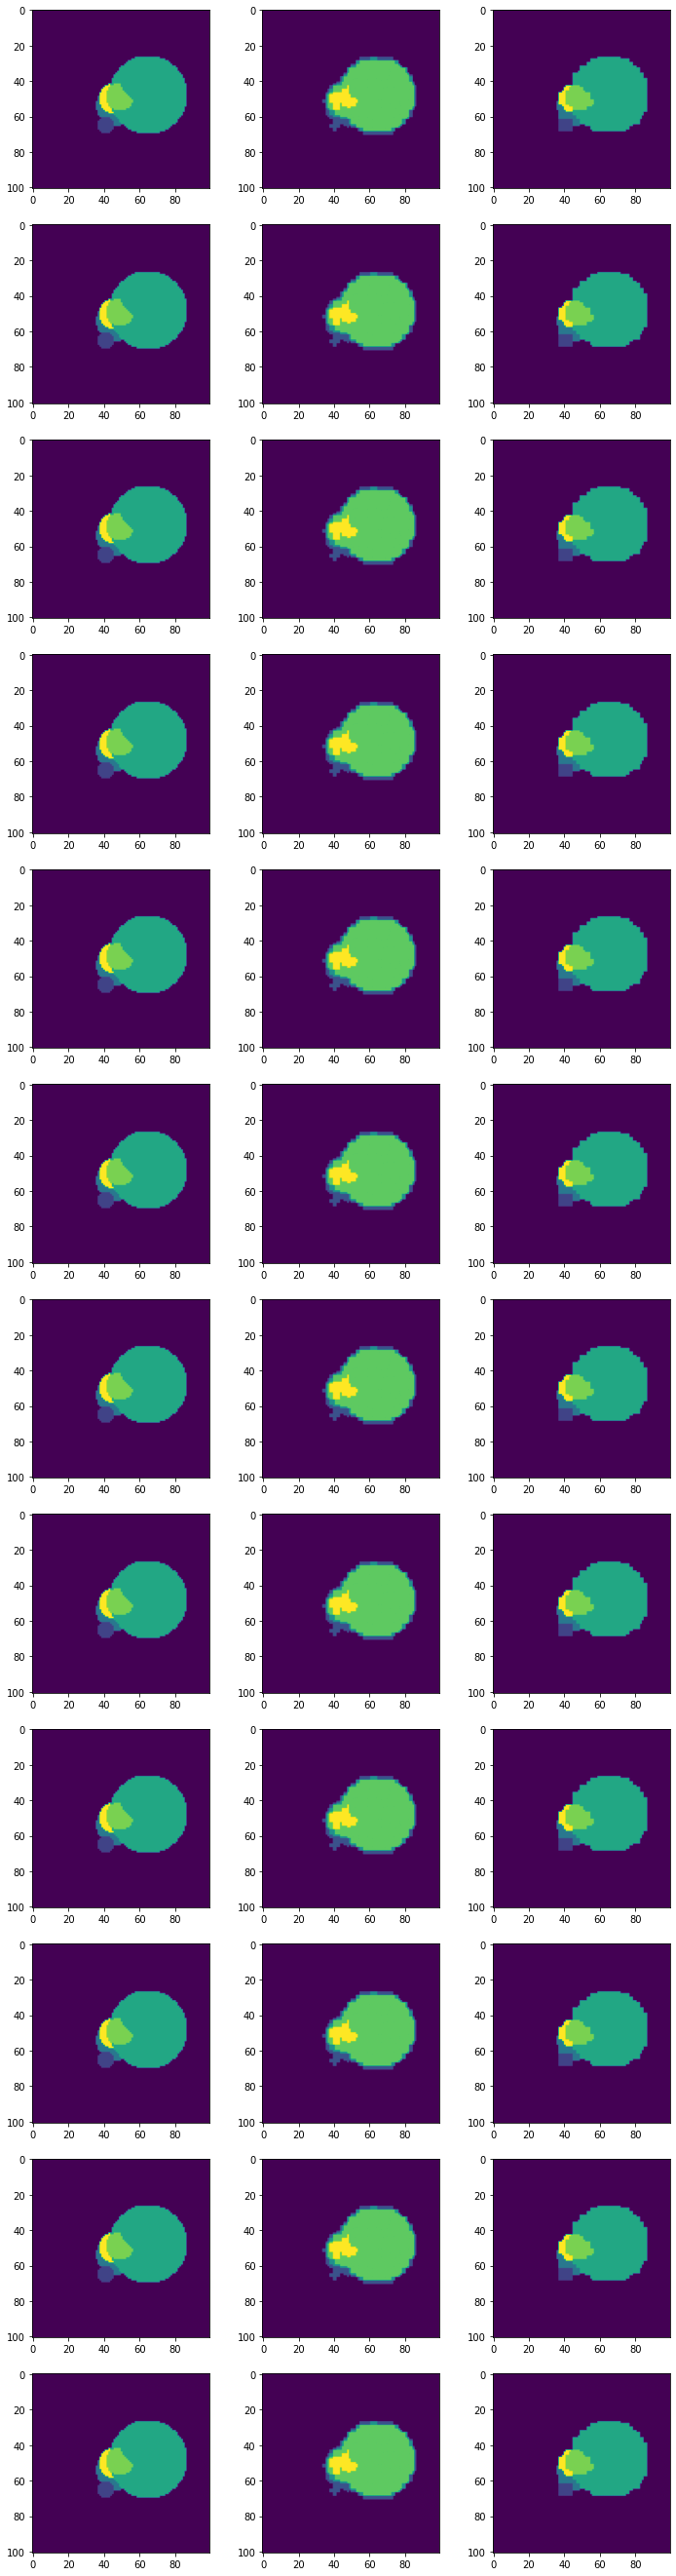

In [90]:
def test_invert():
    import sys
    from copy import deepcopy
    from monai.utils import set_determinism
    from tests.utils import assert_allclose, make_nifti_image    
    from monai.data import DataLoader, Dataset, MetaTensor, create_test_image_3d, decollate_batch
    from monai.transforms import (
        CastToType,
        Compose,
        EnsureChannelFirst,
        Invert,
        LoadImage,
        Orientation,
        RandAffine,
        RandAxisFlip,
        RandFlip,
        RandRotate,
        RandRotate90,
        RandZoom,
        ResizeWithPadOrCrop,
        Spacing,
    )

    mode = 'nearest'
    set_determinism(seed=0)
    im_fname = make_nifti_image(create_test_image_3d(101, 100, 107, noise_max=100)[1])  # label image, discrete
    data = [im_fname for _ in range(12)]
    lazy = True
    base_images = Compose(
        [
            LoadImage(image_only=True),
            EnsureChannelFirst(),
        ]
    )
    transform_old = Compose(
        [
            LoadImage(image_only=True),
            EnsureChannelFirst(),
            # Orientation("RPS"),
            old.Spacing(pixdim=(1.2, 1.01, 0.9), mode=mode, dtype=np.float32),
            old.Flip(spatial_axis=[1, 2]),
            old.Rotate90(spatial_axes=(1, 2)),
            old.Zoom(zoom=0.75, keep_size=True),
            old.Rotate(angle=(np.pi, 0, 0), mode=mode, align_corners=True, dtype=np.float64),
            # RandAffine(prob=0.5, rotate_range=np.pi, mode="nearest"),
            # ResizeWithPadOrCrop(100),
            CastToType(dtype=torch.uint8),
        ]
    )
    transform_new = Compose(
        [
            LoadImage(image_only=True),
            EnsureChannelFirst(),
            # Orientation("RPS"),
            Spacing(pixdim=(1.2, 1.01, 0.9), mode=mode, dtype=np.float32, lazy_evaluation=lazy),
            Flip(spatial_axis=[1, 2], lazy_evaluation=lazy),
            Rotate90(spatial_axes=(1, 2), lazy_evaluation=lazy),
            Zoom(zoom=0.75, keep_size=True, lazy_evaluation=lazy),
            Rotate(angle=(0, 0, np.pi), mode=mode, align_corners=True, dtype=np.float64,
                   lazy_evaluation=lazy),
            # RandAffine(prob=0.5, rotate_range=np.pi, mode="nearest"),
            # ResizeWithPadOrCrop(100),
            CastToType(dtype=torch.uint8),
        ]
    )
#     print(transform._forward_transforms)
    
    # print("loader length =", len(loader))
    fig, ax = plt.subplots(12, 3, figsize=(12, 48))

    for i_tx, tx in enumerate([transform_old, transform_new]):
        # num workers = 0 for mac or gpu transforms
        num_workers = 0 if sys.platform != "linux" or torch.cuda.is_available() else 2
        base_dataset = Dataset(data, transform=base_images)
        base_loader = DataLoader(base_dataset, num_workers=num_workers, batch_size=1)

        dataset = Dataset(data, transform=tx)
        # self.assertIsInstance(transform.inverse(dataset[0]), MetaTensor)
        loader = DataLoader(dataset, num_workers=num_workers, batch_size=1)
        inverter = Invert(transform=tx, nearest_interp=True, device="cpu", post_func=torch.as_tensor)

        for i_d, d in enumerate(base_loader):
            d = decollate_batch(d)
            for item in d:
                print(item.shape)
                if i_tx == 0:
                    ax[i_d, 0].imshow(item[0, ..., item.shape[-1] // 2])

        for i_d, d in enumerate(loader):
            d = decollate_batch(d)
            for item in d:
                orig = deepcopy(item)
                i = inverter(item)
                print(item.shape, i.shape)
                # self.assertTupleEqual(orig.shape[1:], (100, 100, 100))
                # check the nearest interpolation mode
                # assert_allclose(i.to(torch.uint8).to(torch.float), i.to(torch.float))
                # self.assertTupleEqual(i.shape[1:], (101, 100, 107))
                # print(i.shape)
                ax[i_d, i_tx + 1].imshow(i[0, ..., i.shape[-1] // 2])
        # check labels match
        reverted = i.detach().cpu().numpy().astype(np.int32)
        original = LoadImage(image_only=True)(data[-1])
        n_good = np.sum(np.isclose(reverted, original.numpy(), atol=1e-3))
        reverted_name = i.meta["filename_or_obj"]
        original_name = original.meta["filename_or_obj"]
        # self.assertEqual(reverted_name, original_name)
        print("invert diff", reverted.size - n_good)
        # self.assertTrue((reverted.size - n_good) < 300000, f"diff. {reverted.size - n_good}")
        set_determinism(seed=None)
    
test_invert()


# Figure generation for paper

forward_pass_whole
forward_pass_patch_first
round_trip_whole


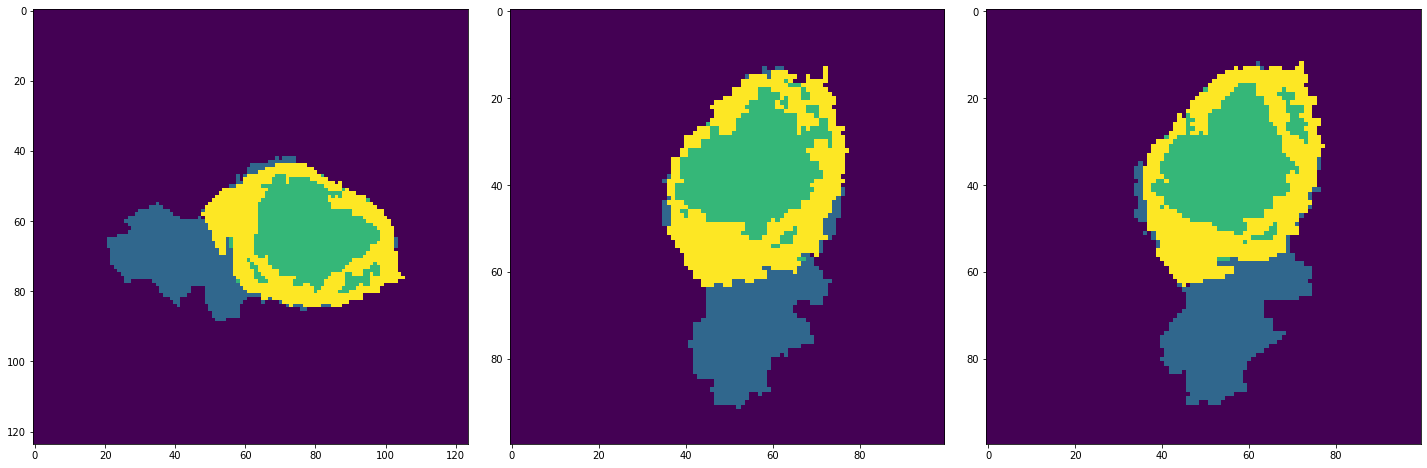

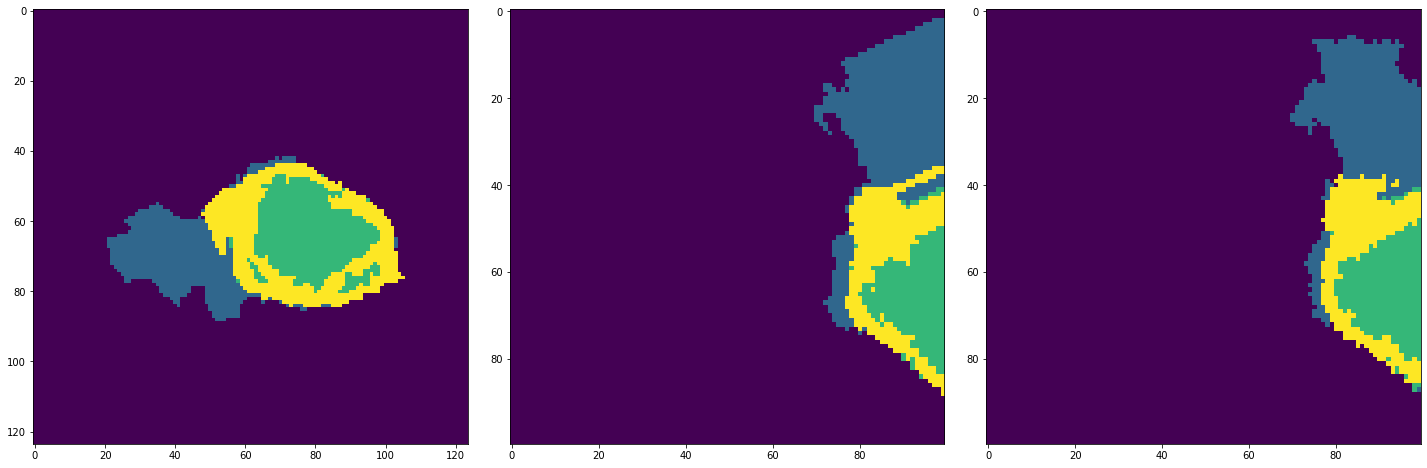

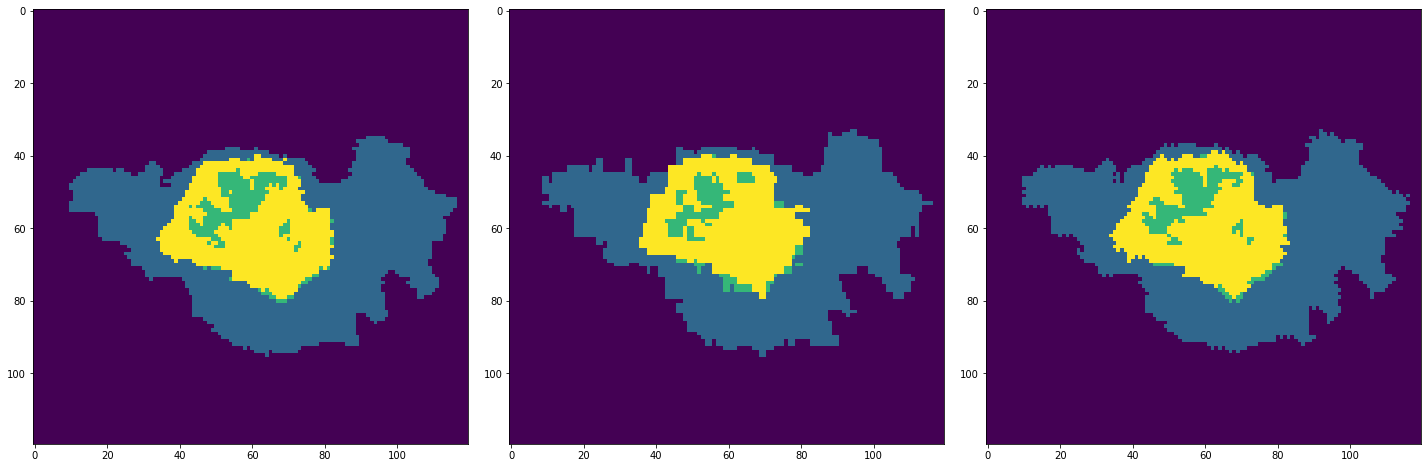

In [129]:
for k, v in display_images.items():
    print(k)
    plot_datas(v, cols=3, tight=True)

 # Old

# 3D rotate

In [ ]:
data = get_img((32, 32, 8))
dmax = data.max()
data[0,7:9,7:9, :] = dmax + 32
data[0,15:17,:, :] = dmax + 64
data[0,0,:, :] = dmax + 96
data[0,:,0, :] = dmax + 128
print(data.shape)
r = Rotate((0, 0, torch.pi / 4), keep_size=False, padding_mode="zeros")

data1 = r(data)

plt.imshow(data1[0,...,4], vmin=data.min(), vmax=data.max())

In [11]:
data_path = '/home/ben/data/Task07_Pancreas'

In [ ]:
entries = []
for r, d, f in os.walk(os.path.join(data_path, 'imagesTr')):
    for fn in f:
        entries.append(os.path.join(r, fn))
entries = sorted(entries)
for e in entries:
    print(e)

In [ ]:
i = LoadImage('nibabelreader')
c = AddChannel()
r = Rotate90(k=1, spatial_axes=(0, 2))

data = os.path.join(data_path, 'imagesTr', 'pancreas_001.nii.gz')
data = i(data)[0]
data = c(data)
md1 = dict(data.meta)
data = r(data)
md2 = dict(data.meta)

keys = sorted(set(md1.keys()).union(md2.keys()))
print(keys)
for k in keys:
    v1 = md1.get(k, None)
    v2 = md2.get(k, None)
    if isinstance(v1, np.ndarray):
        if np.isnan(v1).all() and np.isnan(v2).all():
            equiv = True
        else:
            equiv = np.allclose(v1, v2)
    elif isinstance(v1, torch.Tensor):
        equiv = torch.allclose(v1, v2)
    else:
        equiv = v1 == v2

    print(k, equiv)
    if not equiv:
        print("v1:", v1)
        print("v2:", v2)

In [8]:
a = 5
b = None
print(b or a)

5


m1
 [[ 1.  0. -8.]
 [ 0.  1. -8.]
 [ 0.  0.  1.]]
m2
 [[ 7.07106781e-01 -7.07106781e-01 -8.88178420e-16]
 [ 7.07106781e-01  7.07106781e-01 -1.13137085e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[8. 8. 1.] [0. 0. 1.]
[0. 0. 1.] [-8. -8.  1.]
[ 0. 32.  1.] [-8. 24.  1.]
[32.  0.  1.] [24. -8.  1.]
[32. 32.  1.] [24. 24.  1.]
[8. 8. 1.] [0. 0. 1.]
[0. 0. 1.] [-8.88178420e-16 -1.13137085e+01  1.00000000e+00]
[ 0. 32.  1.] [-22.627417   11.3137085   1.       ]
[32.  0.  1.] [22.627417  11.3137085  1.       ]
[32. 32.  1.] [2.66453526e-15 3.39411255e+01 1.00000000e+00]


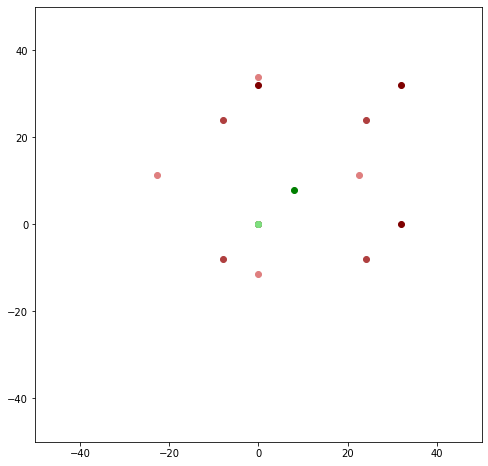

In [5]:
rtn = 0
rtn = torch.pi / 4
rsin = math.sin(rtn)
rcos = math.cos(rtn)

mt = np.asarray([[1.0, 0.0, -8.0],
                 [0.0, 1.0, -8.0],
                 [0.0, 0.0, 1.0]])

mid = np.asarray([[1.0, 0.0, 0.0],
                 [0.0, 1.0, 0.0],
                 [0.0, 0.0, 1.0]])

mrpre = np.asarray([[1.0, 0.0, -16.0],
                    [0.0, 1.0, -16.0],
                    [0.0, 0.0, 1.0]])

mr = np.asarray([[rcos, -rsin, 0.0],
                [rsin, rcos, 0.0],
                [0.0, 0.0, 1.0]])

mrpost = np.asarray([[1.0, 0.0, 16.0],
                    [0.0, 1.0, 16.0],
                    [0.0, 0.0, 1.0]])

m1 = mt
m2 = mr @ m1

print("m1\n", m1)
print("m2\n", m2)

vs = [np.asarray([8.0, 8.0, 1.0]), np.asarray([0.0, 0.0, 1.0]), np.asarray([0.0, 32.0, 1.0]),
      np.asarray([32.0, 0.0, 1.0]), np.asarray([32.0, 32.0, 1.0])]

cs0 = ['#007f00', '#7f0000', '#7f0000', '#7f0000', '#7f0000']
cs1 = ['#3faf3f', '#af3f3f', '#af3f3f', '#af3f3f', '#af3f3f']
cs2 = ['#7fdf7f', '#df7f7f', '#df7f7f', '#df7f7f', '#df7f7f']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
for c, v in zip(cs0, vs):
    mv = mid @ v
    ax.scatter(mv[0], mv[1], color=c)
    
for c, v in zip(cs1, vs):
    mv = m1 @ v
    print(v, mv)
    plt.scatter(mv[0], mv[1], color=c)

for c, v in zip(cs2, vs):
    mv = m2 @ v
    print(v, mv)
    plt.scatter(mv[0], mv[1], color=c)


In [47]:
import torch

tc = torch.nn.ConvTranspose3d(32,
                              32,
                              kernel_size=3,
                              stride=(2, 2, 1),
                              padding=(1, 1, 1),
                              output_padding=(1, 1, 0)
                             )

t = torch.Tensor(np.zeros((1, 32, 64, 64, 16)))
print(t.shape)

t_ = tc.forward(t)
print(t_.shape)

torch.Size([1, 32, 64, 64, 16])
torch.Size([1, 32, 128, 128, 16])


In [8]:
import math

print(math.sqrt(10))
print(10**(1/3))

3.1622776601683795
2.154434690031884


In [42]:
dl = DiceLoss()

r1 = torch.tensor([[1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
r2 = torch.tensor([[0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0], [0, 1, 1, 1, 0, 0], [0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
print(dl(r1, r2))

tensor(0.5556)
